# <center>Milestone 2</center> 

In [87]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import json

In [88]:
# Keyword Search
import spacy
from collections import Counter
import nltk
from nltk import punkt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

## 1. Data Loading

> We start by loading the CMU Movies Summary Corpus datasets obtained from http://www.cs.cmu.edu/~ark/personas/. 

In [97]:
# Paths

DATA_PATH = "data/"


# Specific paths for all datasets

MOVIES_FOLDER = DATA_PATH + "MovieSummaries/"
MOVIES_DATASET = MOVIES_FOLDER + "movie.metadata.tsv"
CHARACTERS_DATASET = MOVIES_FOLDER + "character.metadata.tsv"
CHARACTERS_NAMES_DATASET = MOVIES_FOLDER + "name.clusters.txt"
CHARACTERS_TYPES_DATASET = MOVIES_FOLDER + "tvtropes.clusters.txt"
PLOTS_DATASET = MOVIES_FOLDER + "plot_summaries.txt"
ETHNICITIES_DATASET = MOVIES_FOLDER + "ethnicities.wikidata.csv"

In [98]:
# Load movies metadata

movies = pd.read_csv(MOVIES_DATASET, sep='\t', names=['id_wiki','id_freebase','name','date',
                                                      'box_office','runtime','lang','country','genre'])
movies.head(3)

OSError: [Errno 116] Stale file handle: 'data/MovieSummaries/movie.metadata.tsv'

In [97]:
# Load characters metadata

characters = pd.read_csv(CHARACTERS_DATASET, sep='\t', names=['id_wiki_movie', 'id_freebase_movie', 'movie_release_date', 'character_name',
                                                      'actor_birth_date','actor_gender', 'actor_height', 'actor_ethnicity_freebase_id', 'actor_name',
                                                      'actor_age_movie_release', 'character_actor_freebase_map_id', 'character_id_freebase',
                                                      'actor_id_freebase'])
characters.head(3)

,id_wiki_movie,id_freebase_movie,movie_release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity_freebase_id,actor_name,actor_age_movie_release,character_actor_freebase_map_id,character_id_freebase,actor_id_freebase
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l


In [98]:
# Load characters' names metadata

characters_names = pd.read_csv(CHARACTERS_NAMES_DATASET, sep='\t', names=['character_name', 'character_actor_freebase_map_id'])

characters_names.head()

,character_name,character_actor_freebase_map_id
0,Stuart Little,/m/0k3w9c
1,Stuart Little,/m/0k3wcx
2,Stuart Little,/m/0k3wbn
3,John Doe,/m/0jyg35
4,John Doe,/m/0k2_zn


In [99]:
# Load characters' types metadata

characters_types = pd.read_csv(CHARACTERS_TYPES_DATASET, sep='\t', names=['character_type', 'character_actor_freebase_map_id'])

characters_types.head()

,character_type,character_actor_freebase_map_id
0,absent_minded_professor,"{""char"": ""Professor Philip Brainard"", ""movie"":..."
1,absent_minded_professor,"{""char"": ""Professor Keenbean"", ""movie"": ""Richi..."
2,absent_minded_professor,"{""char"": ""Dr. Reinhardt Lane"", ""movie"": ""The S..."
3,absent_minded_professor,"{""char"": ""Dr. Harold Medford"", ""movie"": ""Them!..."
4,absent_minded_professor,"{""char"": ""Daniel Jackson"", ""movie"": ""Stargate""..."


In [100]:
# Load plot summaries' metadata

plot_summaries = pd.read_csv(PLOTS_DATASET, sep='\t', names=['id_wiki_movie', 'summary'])

plot_summaries.head()

,id_wiki_movie,summary
0,23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
1,31186339,The nation of Panem consists of a wealthy Capi...
2,20663735,Poovalli Induchoodan is sentenced for six yea...
3,2231378,"The Lemon Drop Kid , a New York City swindler,..."
4,595909,Seventh-day Adventist Church pastor Michael Ch...


> We have chosen to enrich our datasets by incorporating ethnicities' Freebase IDs (obtained from https://query.wikidata.org) to facilitate the study of ethnicity representation in cinema.

In [101]:
# Load ethnicities metadata (ethnicities corresponding to freebase IDs obtained from wikidata) 

ethnicities_original = pd.read_csv(ETHNICITIES_DATASET, names=['wikidata_url', 'actor_ethnicity', 'actor_ethnicity_freebase_id'])


# Drop the wikidata_url as this will not be needed

ethnicities = ethnicities_original.drop('wikidata_url', axis = 1)

ethnicities.head()

,actor_ethnicity,actor_ethnicity_freebase_id
0,Hindu,/m/03kbr
1,European Americans,/m/02vsw1
2,Slavs,/m/0790v
3,Aymara,/m/01g3rx
4,Swiss,/m/025_0f0


In [102]:
# Merging of the ethnicities dataset into the characters dataset

characters_ethnicities = characters.merge(ethnicities, how = 'left', on = ['actor_ethnicity_freebase_id'])

characters_ethnicities.head()

,id_wiki_movie,id_freebase_movie,movie_release_date,character_name,actor_birth_date,actor_gender,actor_height,actor_ethnicity_freebase_id,actor_name,actor_age_movie_release,character_actor_freebase_map_id,character_id_freebase,actor_id_freebase,actor_ethnicity
0,975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7,NaN
1,975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4,NaN
2,975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l,African Americans
3,975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc,NaN
4,975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg,NaN


## 2. General statistics about the dataset

> The aim of this first section is to explore the size of the movie dataset and get a sense of its scope.

In [91]:
movies_df = movies.copy()

**2.1) Initial data processing**

> In order to explore the dataset, some of the data in the movies dataset has to be preprocessed, because it is not in a format we can use. This is the case for the movie release date, the movie genre, the country of production and the movie languages.

In [104]:
# THIS CELL SHOULD BE RUN ONLY ONCE


# TO DO : MAYBE REMOVE NaNs HERE (because otherwise there are countries and genres 'N' and 'a'

# movie release date transformed to datetime format (we decided to only keep the years as we don't need the month and day information)
# one weird value at index 62836, date is 1010-12-02 --> could not be converted to datetime so replaced by NaT
# TO DO : DON'T FORGET TO REMOVE NaT VALUES LATER!!!!

movies_df['date'] = pd.to_datetime(movies_df['date'], errors = 'coerce', format = 'mixed').dt.year


# genres, countries and languages are given as dictionaries in the form of strings --> dictionary has to be extracted from the string
# we decided to convert the dictionary to a list, keeping only the names (not the id), to make data handling easier

movies_df['genre'] = movies_df['genre'].apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')
movies_df['country'] = movies_df['country'].copy().apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')
movies_df['lang'] = movies_df['lang'].apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN')

**2.2) Exploring the total number of movies in the dataset.**

In [105]:
print("The total number of movies is :", movies_df.shape[0])

The total number of movies is : 81741


**2.3) Exploring the number of years covered by the dataset and the number of movies produced per year.**

In [106]:
print("Movie release years range: ", movies_df['date'].min(), "-", movies_df['date'].max())

Movie release years range:  1888.0 - 2016.0


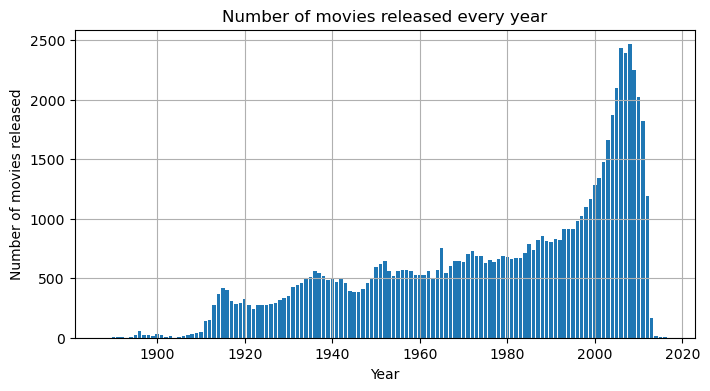

In [107]:
# calculating the number of movies per year

movies_per_year = movies_df['date'].value_counts()


# plotting the number of movies per year

plt.figure(figsize = (8, 4))
plt.bar(movies_per_year.index, movies_per_year.values)
plt.xlabel('Year')
plt.ylabel('Number of movies released')
plt.title('Number of movies released every year')
plt.grid(True)
plt.show()

**2.4) Exploring the different movie genres.** 

>What are the 20 genres that are the most represented? And how many movies of each genre are there?
>
>Since in some cases there are multiple genres for one movie, the value in the genre column is a list. In order to be able to analyze the genres separately (and not as a part of a list of genres for one given movie), we concatenated all these lists to make a big list containing all the instances of all genres.
Then we converted the list back to a pandas series, in order to directly obtain the number of movies for each genre (using value_counts()).

In [108]:
# making one big list with all instances of all genres

genres_list = []
for genres in movies_df['genre'] : genres_list += genres


# transforming the list into a series

genres_df = pd.Series(genres_list)

# number of movies for each genre

movies_per_genre = genres_df.value_counts()


# top 20 genres with number of instances

top_20_genres = movies_per_genre[:20]

print('Top 20 most common genres, with number of movies')
top_20_genres

Top 20 most common genres, with number of movies


Drama               34007
Comedy              16349
Romance Film        10234
Black-and-white      9094
Action               8798
Thriller             8744
Short Film           8141
World cinema         7155
Crime Fiction        6948
Indie                6897
Documentary          5630
Horror               5280
Silent film          5250
Adventure            4963
Family Film          4598
N                    4588
Action/Adventure     4561
Comedy film          4362
Musical              4160
Animation            3534
Name: count, dtype: int64

**2.5) Exploring the production countries of the movies in the dataset.**

>What are the top 20 countries producing most movies? And how many movies were produced in each country?
>
>We proceded the same ways as in 2.4), first making a list, then tranforming it into a dataframe to use value_counts().

In [109]:
# making one big list with all instances of all countries

countries_list = []
for countries in movies_df['country'] : countries_list += countries


# transforming the list into a dataframe

countries_df = pd.Series(countries_list)

# number of movies for each country

movies_per_country = countries_df.value_counts()


# top 20 countries with number of movies

top_20_countries = movies_per_country[:20]

print('Top 20 most common countries, with number of movies')
top_20_countries

Top 20 most common countries, with number of movies


United States of America    34408
N                           16308
India                        8411
a                            8154
United Kingdom               7868
France                       4395
Italy                        3163
Japan                        2647
Canada                       2534
Germany                      2393
Argentina                    1468
Hong Kong                    1240
Spain                        1136
Australia                    1114
South Korea                   887
Mexico                        870
Netherlands                   840
Sweden                        657
West Germany                  647
China                         645
Name: count, dtype: int64

**2.6) Exploring the number of different languages of the movies in the dataset.**

> Since there might in some cases be multiple languages for one movie, we proceded similarly to 2.4) and 2.5) by first making a list containing all instances of all languages. As we only wanted to find the total number of different languages and not the number of movies for a specific language, we then converted the list to a set.

In [110]:
# making one big list with all instances of all languages

languages_list = []
for lang in movies_df['lang'] : languages_list += lang


# number of different languages (tranforming the list into a set)

tot_languages = len(set(languages_list))

print('The total number of languages represented in the dataset is :', tot_languages)

The total number of languages represented in the dataset is : 209


**2.7) Exploring the different ethicities of the movie characters.** 

> What are the different ethnicities represented in the dataset?

In [111]:
characters_ethnicities_df = characters_ethnicities.copy()

# making one big list with all instances of all ethnicities

ethnicities_list = characters_ethnicities_df['actor_ethnicity'].to_list()

# transforming the list into a dataframe

ethnicities_df = pd.Series(ethnicities_list)

# number of character for each ethncity

characters_per_ethnicity = ethnicities_df.value_counts()


# top 20 ethnicities with number of characters

top_20_ethnicities = characters_per_ethnicity[:20]

print('Top 20 most common ethnicities, with number of characters')
top_20_ethnicities

Top 20 most common ethnicities, with number of characters


Indian person        16351
African Americans    10159
Jewish people        10121
English people        6165
Irish Americans       3857
Italian Americans     2956
white people          2307
White Americans       2250
Scottish American     2223
Irish people          1637
British people        1433
French                1350
Italians              1305
Tamil                 1215
Punjabis              1155
Malayali              1146
Scottish people       1028
Swedish Americans      977
German Americans       949
Swedes                 905
Name: count, dtype: int64

## 3. Test for feasability of our idea

**3.1) Defining world regions & plotting their movies over time**

>We may want to define different regions of the world, grouping different countries together. We could define the following regions: 
>- Europe 
>- USA + Canada + Australia
>- Middle East
>- Asia
>- Africa
>- South & Central America
>
>--> Check how many movies are contained for each subdivision over time? Do we have enough movies for each division at each timepoint to be able to draw relevant conclusions?
(Here we don't only check if our partitioning is adequate but also the general timespan we can perform our analysis on: WWI may be too early)

In [112]:
# Creating subdivisions of movies

countries_df_2 = movies.copy()
countries_df_2['date'] = pd.to_datetime(countries_df_2['date'], errors = 'coerce', format = 'mixed').dt.year


# Obtain a list of countries contained in the dataset

only_countries = countries_df_2['country'].apply(lambda x: list(json.loads(x).values()) if len(json.loads(x).values()) > 0 else 'NaN').copy()
only_countries = only_countries.to_list()


# Removing all Nan's and making a onedimensional list of all countries contained in the dataset

only_countries = [x for x in only_countries if x != "NaN"]
only_countries = [item for sublist in only_countries for item in sublist]


# Creating a list with all unique countries contained in the dataset

only_countries_unique = []
for item in only_countries:
    if item not in only_countries_unique:
        only_countries_unique.append(item)

        
# Create the corresponding regions for later analysis containing all countries from the dataset

europe_countries =  ['United Kingdom', 'Croatia', 'Ukraine', 'Luxembourg', 'Belgium', 'Sweden', 'Switzerland', 'Greece', 'Ireland',  'Iceland', 'Poland', 'Italy', 'Denmark',  'Scotland', 'Finland', 'Albania', 'Portugal', 'Northern Ireland', 'Austria',  'Netherlands', 'Monaco', 'Spain',  'England',  'German Democratic Republic', 'France', 'Nazi Germany', 'West Germany',  'Germany', 'Weimar Republic', 'Kingdom of Italy', 'Kingdom of Great Britain', 'Isle of Man', 'Lithuania', 'Malta', 'Czech Republic',  'Czechoslovakia', 'Slovakia', 'Romania', 'Norway', 'Serbia', 'Slovenia', 'Bulgaria', 'Slovak Republic', 'Ukrainian SSR',  'Ukranian SSR',  'Estonia',  'Soviet occupation zone', 'Bosnia and Herzegovina', 'Socialist Federal Republic of Yugoslavia', 'Yugoslavia', 'Wales', 'Hungary', 'Federal Republic of Yugoslavia',  'Serbia and Montenegro', 'Republic of Macedonia', 'Montenegro', 'Cyprus', 'Crime']
middle_east_countries = ['Lebanon', 'Iran', 'United Arab Emirates', 'Iraq', 'Turkey', 'Iraqi Kurdistan', 'Jordan', 'Mandatory Palestine', 'Palestinian territories', 'Palestinian Territories', 'Armenia', 'Georgia', 'Kuwait', 'Georgian SSR', 'Israel', 'Turkmenistan', 'Qatar', 'Bahrain', 'Azerbaijan']
asia_countries = ['Hong Kong', 'Nepal', 'Indonesia', 'China',  'Taiwan', 'Cambodia', 'Vietnam', 'Sri Lanka', 'Singapore', 'Thailand', 'Mongolia', 'Korea', 'India', 'Malaysia', 'South Korea', 'Philippines', 'Republic of China', 'Japan',  'Soviet Union', 'Bangladesh', 'Russia', 'Pakistan', 'Uzbekistan', 'Afghanistan', 'Macau', 'Uzbek SSR', 'Bhutan', 'Burma']
africa_countries = ['Guinea', 'Cameroon', 'Democratic Republic of the Congo', 'Tunisia', 'Congo', 'Ethiopia', 'Nigeria', 'Libya', 'Zimbabwe', 'Morocco',  'Mali', 'Egypt', 'Burkina Faso', 'Senegal', 'Kenya', 'South Africa', 'Algeria', 'Zambia', 'Guinea-Bissau']
south_central_america_countries =  ['Mexico', 'Colombia', 'Uruguay', 'Puerto Rico',  'Costa Rica', 'Chile', 'Venezuela', 'Peru', 'Bolivia', 'Brazil', 'Cuba', 'Panama', 'Argentina', 'Haiti', 'Bahamas', 'Jamaica', 'Aruba']
other_countries = ['United States of America', 'Canada', 'Australia', 'New Zealand']
outlier_countries = [ 'German Language', 'Malayalam Language'] 


# Check that all countries in the dataset are contained in a certain region

all_countries = europe_countries + middle_east_countries + asia_countries + africa_countries + south_central_america_countries + other_countries + outlier_countries
print(len(only_countries_unique))
print(len(all_countries))

147
147


**Important Observations:**
- A movie can be produced by multiple countries at the same time
- In the entries of some countries, there are typos or different syntax which is why these countries are not considered identical. To avoid any effects this can have, all manners of which the country was written was included in the grouping. Examples of this are:
    - “Ukrainian SSR” vs “Ukranian SSR”
    - “Socialist Federal Republic of Yugoslavia” vs “Yugoslavia” vs “Federal Republic of Yugoslavia”
    - “Palestinian territories” vs “Palestinian Territories”
- There are a few entries which do not correspond to countries. These were grouped into the list "outlier_countries" and will not be used for country analysis, as we cannot be completely sure what countries produced them. Examples of this are:
    - “German Language”
    - “Malayalam Language”

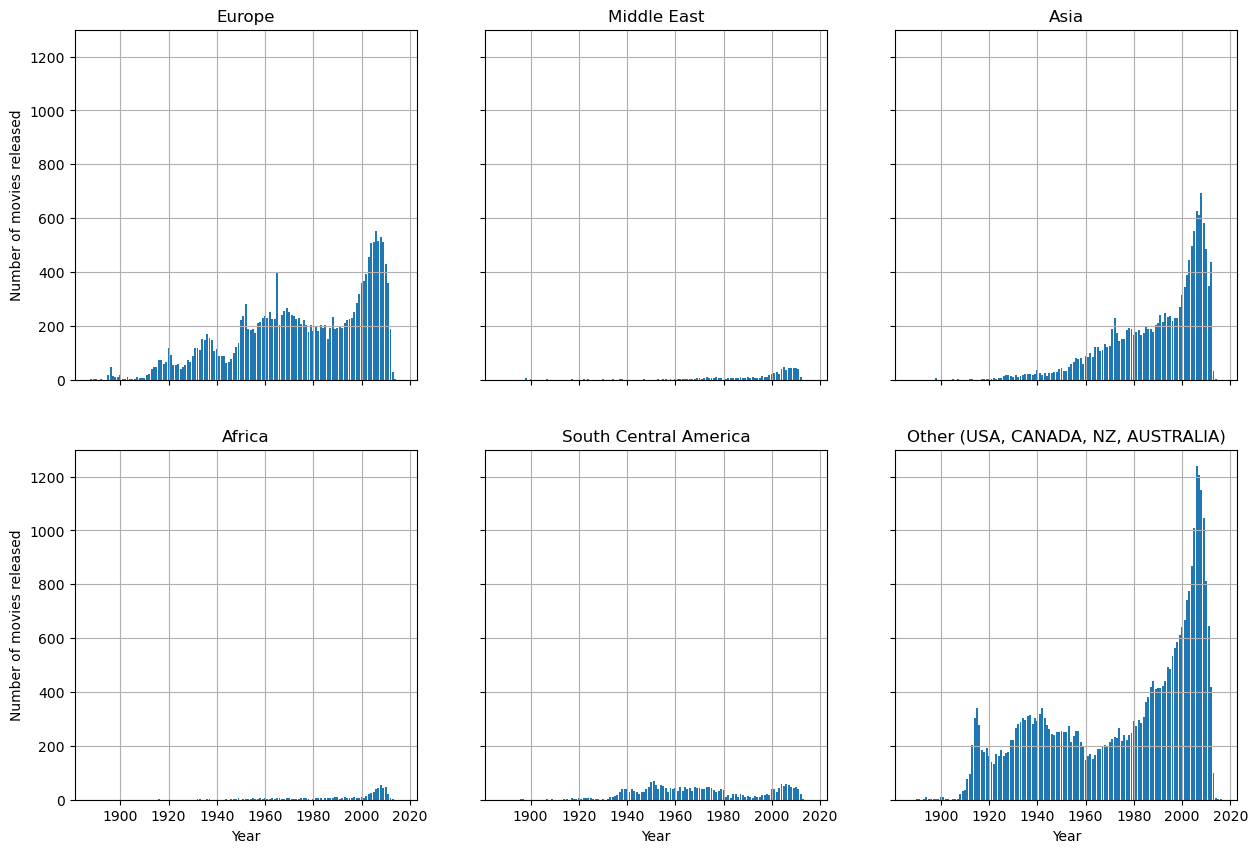

In [81]:
# Check how many movies are contained for each subdivision over time, constructing subplots with the same y-axis

fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)


# Check for Region Europe

filtered_europe_movies = countries_df_2[countries_df_2['country'].apply(lambda x: any(item in x for item in europe_countries))]
movies_per_year_europe = filtered_europe_movies['date'].value_counts()
axs[0, 0].bar(movies_per_year_europe.index, movies_per_year_europe.values)
axs[0, 0].set_title('Europe')


# Check for Region Middle East

filtered_middle_east_movies = countries_df_2[countries_df_2['country'].apply(lambda x: any(item in x for item in middle_east_countries))]
movies_per_year_middle_east = filtered_middle_east_movies['date'].value_counts()
axs[0, 1].bar(movies_per_year_middle_east.index, movies_per_year_middle_east.values)
axs[0, 1].set_title('Middle East')


# Check for Region Asia

filtered_asia_movies = countries_df_2[countries_df_2['country'].apply(lambda x: any(item in x for item in asia_countries))]
movies_per_year_asia = filtered_asia_movies['date'].value_counts()
axs[0, 2].bar(movies_per_year_asia.index, movies_per_year_asia.values)
axs[0, 2].set_title('Asia')


# Check for Region Africa

filtered_africa_movies = countries_df_2[countries_df_2['country'].apply(lambda x: any(item in x for item in africa_countries))]
movies_per_year_africa = filtered_africa_movies['date'].value_counts()
axs[1, 0].bar(movies_per_year_africa.index, movies_per_year_africa.values)
axs[1, 0].set_title('Africa')


# Check for region South Central America

filtered_south_central_america_movies = countries_df_2[countries_df_2['country'].apply(lambda x: any(item in x for item in south_central_america_countries))]
movies_per_year_south_central_america = filtered_south_central_america_movies['date'].value_counts()
axs[1, 1].bar(movies_per_year_south_central_america.index, movies_per_year_south_central_america.values)
axs[1, 1].set_title('South Central America')


# Check for region Other (includes USA, Australia, New Zealand, Canada)

filtered_other_movies = countries_df_2[countries_df_2['country'].apply(lambda x: any(item in x for item in other_countries))]
movies_per_year_other = filtered_other_movies['date'].value_counts()
axs[1, 2].bar(movies_per_year_other.index, movies_per_year_other.values)
axs[1, 2].set_title('Other (USA, CANADA, NZ, AUSTRALIA)')

for ax in axs.flat:
    ax.set(xlabel='Year', ylabel='Number of movies released')
    ax.grid(True)

    
# Hide x labels and tick labels for top plots and y ticks for right plots.

for ax in axs.flat:
    ax.label_outer()

plt.show()

In [ ]:
# Check how many movies are contained for each subdivision over time, constructing subplots with individual y-axes

fig, axs = plt.subplots(2, 3, figsize=(15, 10))


# Check for Region Europe

axs[0, 0].bar(movies_per_year_europe.index, movies_per_year_europe.values)
axs[0, 0].set_title('Europe')
axs[0, 0].set_xlabel('Year')
axs[0, 0].set_ylabel('Number of movies released')
axs[0, 0].set_ylim([0, movies_per_year_europe.values.max() * 1.2])  
axs[0, 0].grid(True)


# Check for Region Middle East

axs[0, 1].bar(movies_per_year_middle_east.index, movies_per_year_middle_east.values)
axs[0, 1].set_title('Middle East')
axs[0, 1].set_xlabel('Year')
axs[0, 1].set_ylabel('Number of movies released')
axs[0, 1].set_ylim([0, movies_per_year_middle_east.values.max() * 1.2]) 
axs[0, 1].grid(True)


# Check for Region Asia

axs[0, 2].bar(movies_per_year_asia.index, movies_per_year_asia.values)
axs[0, 2].set_title('Asia')
axs[0, 2].set_xlabel('Year')
axs[0, 2].set_ylabel('Number of movies released')
axs[0, 2].set_ylim([0, movies_per_year_asia.values.max() * 1.2]) 
axs[0, 2].grid(True)


# Check for Region Africa

axs[1, 0].bar(movies_per_year_africa.index, movies_per_year_africa.values)
axs[1, 0].set_title('Africa')
axs[1, 0].set_xlabel('Year')
axs[1, 0].set_ylabel('Number of movies released')
axs[1, 0].set_ylim([0, movies_per_year_africa.values.max() * 1.2]) 
axs[1, 0].grid(True)


# Check for region South Central America

axs[1, 1].bar(movies_per_year_south_central_america.index, movies_per_year_south_central_america.values)
axs[1, 1].set_title('South Central America')
axs[1, 1].set_xlabel('Year')
axs[1, 1].set_ylabel('Number of movies released')
axs[1, 1].set_ylim([0, movies_per_year_south_central_america.values.max() * 1.2])
axs[1, 1].grid(True)


# Check for region Other (includes USA, Australia, New Zealand, Canada)

axs[1, 2].bar(movies_per_year_other.index, movies_per_year_other.values)
axs[1, 2].set_title('Other (USA, CANADA, NZ, AUSTRALIA)')
axs[1, 2].set_xlabel('Year')
axs[1, 2].set_ylabel('Number of movies released')
axs[1, 2].set_ylim([0, movies_per_year_other.values.max() * 1.2])  
axs[1, 2].grid(True)

plt.tight_layout()
plt.show()

> Since we have realized, that the USA is the country having produced the most movies, we want to explore the option of only grouping the US with Canada (forming the region 'North America') and grouping Australia and New Zealand together (forming the region 'Australia'). This option is evaluated considering the number of movies present for both regions in the plot below. 

Text(0.5, 1.0, 'Australia')

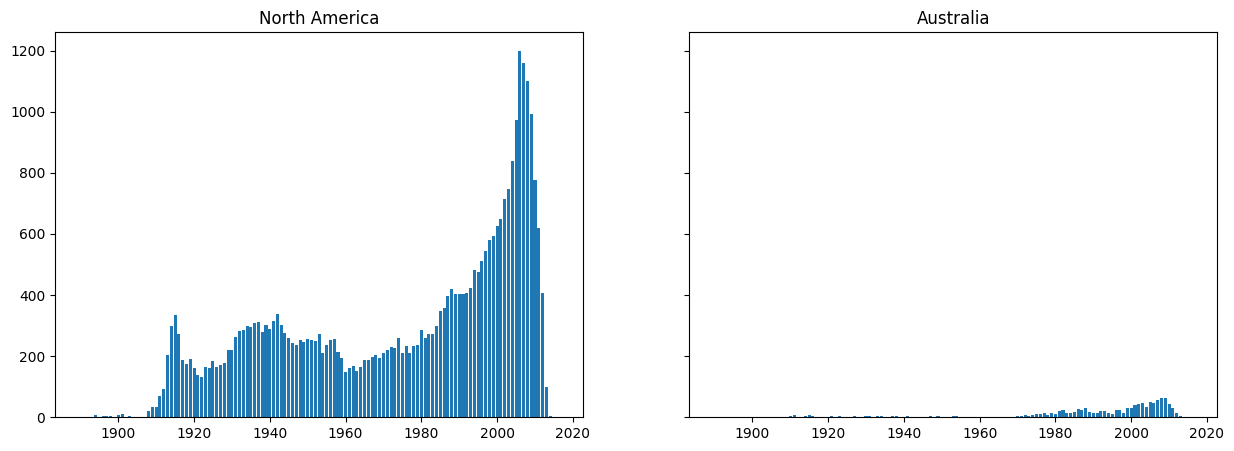

In [ ]:
# Defining new region divisions

north_america_countries = ['United States of America', 'Canada']
australia_countries = ['Australia', 'New Zealand']


# Creating subplots

fig, axs = plt.subplots(1, 2, figsize=(15, 5), sharex=True, sharey=True)

filtered_north_america_movies = countries_df_2[countries_df_2['country'].apply(lambda x: any(item in x for item in north_america_countries))]
movies_per_year_north_america = filtered_north_america_movies['date'].value_counts()
axs[0].bar(movies_per_year_north_america.index, movies_per_year_north_america.values)
axs[0].set_title('North America')

filtered_australia_movies = countries_df_2[countries_df_2['country'].apply(lambda x: any(item in x for item in australia_countries))]
movies_per_year_australia = filtered_australia_movies['date'].value_counts()
axs[1].bar(movies_per_year_australia.index, movies_per_year_australia.values)
axs[1].set_title('Australia')

**3.2) Number and percentage of NAN values contained in some of our datasets**

>Before further analyzing data in datasets' columns we are interested in, we need to investigate how many NAN values they contain and what proportion of the entire data they represent. It might give us insights about how cautious we need to be in our results' interpretations and analysis' conclusions.

In [ ]:
characters_nan_analysis_df = characters.copy()
movies_nan_analysis_df = movies.copy()


# Function counting NAN values and computing NAN percentage in specific columns of some datasets

def compute_nan_count_and_percentage(df, column_name):
    nan_count = (df[column_name].isna() == True).sum()
    nan_percentage = df[column_name].isna().mean() * 100

    print(f"There are {nan_count} NAN values in the {column_name} column of the dataset.")
    print(f"This corresponds to a percentage of {nan_percentage:.2f} % of the {column_name} column total data.\n")


# Printing NAN values' counts and percentages in the characters' dataset for further analysis

print("CHARACTERS' DATASET: \n")
compute_nan_count_and_percentage(characters_nan_analysis_df, 'actor_birth_date')
compute_nan_count_and_percentage(characters_nan_analysis_df, 'actor_gender')
compute_nan_count_and_percentage(characters_nan_analysis_df, 'actor_height')
compute_nan_count_and_percentage(characters_nan_analysis_df, 'actor_ethnicity_freebase_id')
compute_nan_count_and_percentage(characters_nan_analysis_df, 'actor_age_movie_release')
compute_nan_count_and_percentage(characters_nan_analysis_df, 'movie_release_date')


# Printing NAN values' counts and percentages in the movies' dataset for further analysis

print("MOVIES' DATASET: \n")
compute_nan_count_and_percentage(movies_nan_analysis_df, 'box_office')
compute_nan_count_and_percentage(movies_nan_analysis_df, 'lang')
compute_nan_count_and_percentage(movies_nan_analysis_df, 'country')
compute_nan_count_and_percentage(movies_nan_analysis_df, 'genre')

CHARACTERS' DATASET: 

There are 106145 NAN values in the actor_birth_date column of the dataset.
This corresponds to a percentage of 23.55 % of the actor_birth_date column total data.

There are 45609 NAN values in the actor_gender column of the dataset.
This corresponds to a percentage of 10.12 % of the actor_gender column total data.

There are 295845 NAN values in the actor_height column of the dataset.
This corresponds to a percentage of 65.65 % of the actor_height column total data.

There are 344611 NAN values in the actor_ethnicity_freebase_id column of the dataset.
This corresponds to a percentage of 76.47 % of the actor_ethnicity_freebase_id column total data.

There are 158113 NAN values in the actor_age_movie_release column of the dataset.
This corresponds to a percentage of 35.08 % of the actor_age_movie_release column total data.

There are 9995 NAN values in the movie_release_date column of the dataset.
This corresponds to a percentage of 2.22 % of the movie_release_date

>**Results Interpretation**
>
>We will consider that **25%** is a reasonable percentage of NAN values in datasets' columns. If NAN percentage is below that threshold, we would have to be careful when drawing conclusions from that data and analyse rigorously their statistical significance.
>
>Regarding the characters' dataset, we will have to be cautious when dealing with data in the *actor_height*, *actor_ethnicity_freebase_id* and *actor_age_movie_release_date* columns.
>
>Regarding the movies' dataset, we will have to be cautious when dealing with data in the *box_office* column. 
>
>We have two possible solutions for further analysis:
>* either we choose to drop rows containing NAN values in the column we are interested in for our study;
>* or we replace those NAN values with other values with appropriate justifications.

**3.3) Overview of movies' synopsis most frequent words**

> **ATTENTION**
>
>To run the code for this part, you will first need to run the two commands commented in the cell below one time to download the ```punkt```  and ```stopwords``` packages of the ```nltk python``` module. 
>You can comment them again after and run following cells.

In [ ]:
#nltk.download('punkt')
#nltk.download('stopwords')

In [ ]:
from collections import Counter
import nltk
from nltk import punkt
from nltk.corpus import stopwords
from wordcloud import WordCloud

>We created a words' list regrouping all words present in movies' summaries with their associated appearence frequencies. We chose to only visualize the top 50 most frequent words in movies' synopsis through a word cloud image. This gives us a general idea of what the majority of films synopsis are about. 

In [ ]:
plot_summaries_df = plot_summaries.copy()

# Pre-processing summaries' text data

summaries_text = ' '.join(plot_summaries_df['summary']) # Combine all text data into a single string
summaries_words = nltk.word_tokenize(summaries_text.lower()) # Convert to lowercase and tokenize
words_freq = Counter(summaries_words) # Count word frequencies


# Remove common stop words and punctuations

stop_words = set(stopwords.words('english'))
word_freq = {word: freq for word, freq in words_freq.items() if word not in stop_words and word.isalpha()}


# Sort words by frequency in descending order

sorted_word_freq = sorted(word_freq.items(), key=lambda x: x[1], reverse=True)


# Extract the 50 most frequently appearing words in plots' summaries

top_50_words = sorted_word_freq[:49]

In [ ]:
# Printing the list of the top 50 most frequent words in films' summaries

#top_50_words_list = [word for word, _ in top_50_words]
#print(top_50_words_list)

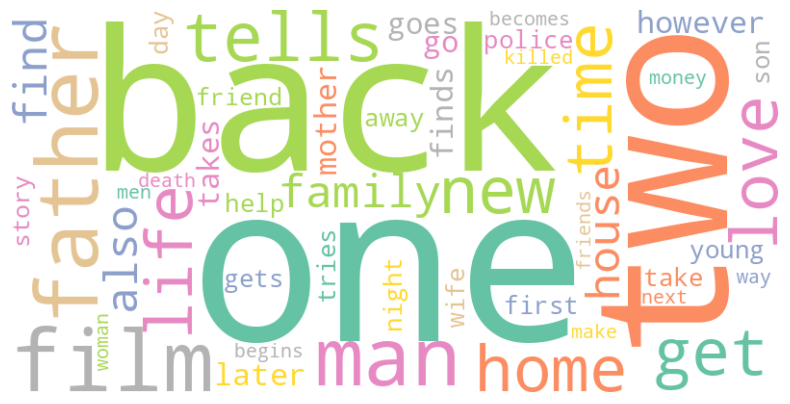

In [28]:
top_50_words_frequencies = dict(top_50_words)


# Defining the word cloud and choosing a colorblind friendly palette

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='Set2').generate_from_frequencies(top_50_words_frequencies)


# Plotting the word cloud

plt.figure(figsize=(8, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')

plt.tight_layout()
plt.show()

>**Results Interpretation**
>
>When focusing on nouns, a lot of them refer to humans' personal spheres such as "father", "mother", "son", "friend", "wife" or "home". Some of them are also associated with general life concepts ("time", "money", "love", "life"). Also, we can see that few words evoke negativity or fear ("killed", "death", "police", "night"). All these observations can suggest that the majority of films focus on arising strong emotions through their storylines.
>
>Now looking at verbs and their conjugations, one can notice that the majority of them are referring to actions: "takes", "get", "goes", "finds". This can suggest that movies' summaries might be centered around characters' actions to tease and attract public.

**3.4) Characters Features Analysis**

Interesting questions:
* How are we able to extract the "villain" and the "main character" from a movie plot? 
* How can we get their typical characteristics? 
* Can we test the principle of this for a specific movie?

The code below allows to detect from a movie summary the movies' characters, the adjectives that characterize them and the verbs associated to them in the text. Here, a random movie summary has been chosen just to show that the code works.

**ATTENTION:** 

Pour run le code suivant, vous devez d'abord installer un environnement virtuel qui vous permettra d'intégrer le module SpaCy et de load la langue anglaise, ce qui permet de faire des analyses de textes non-biaisées et rapides.

Pour cela, vous devez effectuer les commandes suivantes dans votre terminal sur Jupyter Notebook:
```
my_venvs_create spacy_env
my_venvs_activate spacy_env
pip install spacy
python -m spacy download en_core_web_sm
my_kernels_create py3_spacy "Py3 Spacy"
my_venvs_deactivate
```
Et après, pour run votre notebook, choisissez comme kernel celui que vous venez de créer "Py3 Spacy".

In [29]:
import spacy

In [30]:
# Load the English language model

nlp = spacy.load("en_core_web_sm")


# Sample a movie summary

movie_summary_example = plot_summaries['summary'][1]


# Process the movie summary

doc = nlp(movie_summary_example)


# Create two dictionaries to store characters, their related adjectives and verbs

characters_adjectives = {}
characters_verbs = {}


# Extract character's names (assuming it's mentioned as a proper noun)

characters_names = []
for entity in doc.ents:
    if entity.label_ == "PERSON":
        characters_names.append(entity.text)


# Dropping characters' duplicates

characters_names_unique = []
for item in characters_names:
    if item not in characters_names_unique:
        characters_names_unique.append(item)

In [31]:
# Extract adjectives related to each character in the movie's summary

adjectives = []
for character in characters_names_unique:
    for token in doc: 
        if token.pos_ == "ADJ" and token.head.text == character:
            adjectives.append(token.text)
   
        if len(adjectives) == 0 :
            characters_adjectives[character] = ['No related adjectives.']
        else:
            characters_adjectives[character] = adjectives
    
    adjectives = []

    
# Print the results

print("THE CHARACTERS AND THEIR RELATED ADJECTIVES: \n")
for character_name, adjectives in characters_adjectives.items():
    print(f"{character_name}: {', '.join(adjectives)} \n")

THE CHARACTERS AND THEIR RELATED ADJECTIVES: 

Katniss: tormenting 

Peeta Mellark: No related adjectives. 

baker: No related adjectives. 

Peeta: No related adjectives. 

Haymitch Abernathy: No related adjectives. 

Haymitch: No related adjectives. 

Rue: No related adjectives. 

Snow: No related adjectives. 

Seneca Crane: No related adjectives. 

Thresh: No related adjectives. 

Cato: No related adjectives. 

Crane: No related adjectives. 



In [32]:
# Extract verbs related to each character in the movie's summary

verbs = []
for character in characters_names_unique:
    for sentence in doc.sents:
        for token in sentence: 
            if token.pos_ == "VERB" and character in [word.text for word in sentence]:
                verbs.append(token.text)
            if len(verbs) == 0:
                characters_verbs[character] = ['No related verbs.']
            else:
                characters_verbs[character] = verbs
    verbs = []


# Print the results

print("THE CHARACTERS AND THEIR RELATED VERBS: \n")
for character_name, verbs in characters_verbs.items():
    print(f"{character_name}: {', '.join(verbs)} \n")

THE CHARACTERS AND THEIR RELATED VERBS: 

Katniss: take, gave, starving, taken, accompanied, reveals, televised, begin, killed, survives, ignoring, run, tempting, strewn, called, find, corner, drops, warned, run, cares, recovers, has, draw, destroys, setting, planted, runs, hears, calling, throws, dodges, causing, stab, shoots, presented, crossed, convince, make, avoid, inciting, hearing, finds, promises, go, falls, heads, kills, overhearing, killing, spares, kill, force, flee, encounter, wounds, hurls, shoots, spare, prolonged, allowing, revoked, tells, shoot, warns, made 

Peeta Mellark: No related verbs. 

baker: gave, starving 

Peeta: gave, starving, taken, accompanied, reveals, discovers, meant, said, forms, warned, run, presented, crossed, convince, make, avoid, inciting, hearing, finds, begs, risk, getting, works, keeping, dies, eating, stole, knew, kill, force, flee, encounter, wounds, hurls, allowing, revoked, tells, shoot, locked, considers 

Haymitch Abernathy: No related v

**3.5) Presence of outlier characteristics**

We need to analyze each of the important characteristics for us to see if there are other values apart from NaN's that we cannot use for our data analysis. Ex: "German Language" in column "Country".
The important characteristics are:
- Actor DOB
- Actor Gender
- Actor Height
- Actor Ethnicity
- Actor Age at movie release
- Movie Release Date
- Movie Box Office Revenue
- Movie Languages
- Movie Countries
- Movie Genres

**3.5.1) Outlier Characteristics of Actor DOB**

In [33]:
# Testing for outliers contained in the "actor_birth_date" column

from datetime import datetime
import re

outlier_dates_birth = [date for date in characters['actor_birth_date'] if not re.match(r'\d{4}-\d{2}-\d{2}', str(date))]
outlier_dates_birth_unique = list(set(outlier_dates_birth))

print(outlier_dates_birth_unique[:20])


# Check for dates out of our timerange

impossible_dates_birth = []

for date in outlier_dates_birth:
    if isinstance(date, str): # Don't take into consideration nan's
        year_string = date.split('-')[0] # Extract the 'year' from the date
        if (int(year_string) > 2016 or int(year_string) < 1800):  
            impossible_dates_birth.append(date)

        
print(impossible_dates_birth)

['1930', '1804', '1931', '1945-05', '1931-12', '1961-10', '1950-12', '1942', '1965-09', '1919-01', '1909', '1978-11', '1910', '1973', '1977-11', '1922-09', '1940-02', '2002-08', '2006-11', '1974-10']
['1498', '0183', '1498', '2050']


Important observations of the column 'actor_birth_date':
- Contains NaN's
- Contains dates of different detail:
    - YYYY-MM-DD
    - YYYY-MM
    - YYYY
- Contains invalid dates (ex: '2050', which would be an actor born after the year our dataset was collected in or '1498' where the actor would certainly already be dead when the movie is produced)

Comment: Only the first 20 elemenents of outlier actor birth dates were printed here due to clarity reasons, however all were evaluated when observing the dataset. 

**3.5.2) Outlier Characteristics of Actor Gender**

In [34]:
# Testing for outliers contained in the "actor_gender" column

outlier_gender = [gender for gender in characters['actor_gender'] if gender not in ('F', 'M')]
outlier_gender_unique = list(set(outlier_gender))

print(outlier_gender_unique)


[nan]


Important observations of the column 'actor_gender':
- Contains NaN's
- Contains no invalid genders (ex: 'J' or '3')

**3.5.3) Outlier Characteristics of Actor Height**

In [35]:
# Testing for outliers contained in the "actor_height" column

outliers_height = [height for height in characters['actor_height'] if type(height) != float]
outliers_height_unique = list(set(outliers_height))
print(outliers_height_unique)


# Testing for actor_heights that are out of range (smaller than 1m or bigger than 3m)

impossible_height = [height for height in characters['actor_height'] if (height >= 3 or height <= 1)]
print(impossible_height)

[]
[0.813, 0.88, 180.0, 0.88, 0.83, 510.0, 180.0, 0.813, 0.813, 0.88, 0.88, 1.0, 510.0, 0.813, 0.94, 0.813, 0.813, 0.88, 0.88, 0.813, 1.0, 510.0, 0.813, 180.0, 1.0, 0.813, 1.0, 1.0, 0.83, 510.0, 510.0, 1.0, 1.0, 510.0, 0.813, 0.813, 180.0, 1.0, 510.0, 0.88, 510.0, 1.0, 510.0, 0.813, 510.0, 510.0, 0.813, 0.88, 0.61, 0.61, 0.88]


Important observations of the column 'actor_height':
- Contains NaN's (NaN's are recognized as floats here, are present)
- Apart from Nan's there are no non-float values
- Column does contain some improbable heights of actors that are either too big or too small to be possible (<1m or >3m). Some of those may be due to child-actors, however it is very possible that some are due to an error in units (inches or cm).

**3.5.4) Outlier Characteristics of Actor Ethnicity**

In [36]:
# Testing for outliers contained in the 'actor_ethnicity' column of 'characters_ethnicities' dataset

listing_ethnicities = [ethnicity for ethnicity in characters_ethnicities['actor_ethnicity']]
unique_ethnicities = list(set(listing_ethnicities))
print(unique_ethnicities[:20])

['Berber', 'Serbs of Bosnia and Herzegovina', 'Italian Brazilians', 'Cuban American', 'Azerbaijanis', 'Criollo people', 'Croatian Australians', 'English people', 'Eurasian', 'Ukrainian Americans', 'Bosnians', 'Greeks in South Africa', 'Hindu', 'Bohemian', 'Omaha people', 'Pakistanis', 'Lithuanian American', 'British Pakistanis', 'Han Chinese people', 'Thai people']


Important observations of the column 'actor_ethnicity':
- Contains NaN's
- Contains very detailed ethnicities (example: Croatian Canadians)
- Some invalid ethnicities are present, such as: 'Q25467191', 'history of the Jews in India', 'Q31340083' and 'names of the Greeks'

Comment: Only the first 20 elemenents of ethnicities were printed here due to clarity reasons, however all were evaluated when observing the dataset. 

**3.5.5) Outlier Characteristics of Actor Age at Movie Release**

In [37]:
# Testing for outliers contained in the 'actor_age_movie_release' column

outliers_age_release = [age_release for age_release in characters['actor_age_movie_release'] if type(age_release) != float]
outliers_age_release_unique = list(set(outliers_age_release))
print(outliers_age_release_unique)


# Testing for actor_age_movie_release that are out of range (<0)

impossible_age_release = [age_release for age_release in characters['actor_age_movie_release'] if (age_release < 0)]
print(impossible_age_release[:20])

[]
[-29.0, -12.0, -18.0, -48.0, -17.0, -12.0, -26.0, -12.0, -10.0, -12.0, -5.0, -25.0, -14.0, -5.0, -29.0, -7.0, -21.0, -13.0, -1.0, -2.0]


Important observations for the column 'actor_age_movie_release':
- Contains NaN's (NaN's are recognized as floats here, are present)
- Apart from Nan's there are no non-float values
- Column does contain some impossible ages of actors at movie release (such as <0)

Comment: Only the first 20 elemenents of impossible ages were printed here due to clarity reasons, however all were evaluated when observing the dataset.

**3.3.6) Outlier Characteristics of Movie Release Dates**

In [38]:
# Testing for outliers contained in the "movie_release_date" column

outlier_release_dates = [date for date in characters['movie_release_date'] if not re.match(r'\d{4}-\d{2}-\d{2}', str(date))]
outlier_release_dates_unique = list(set(outlier_release_dates))

print(outlier_release_dates_unique[:20])


# Check for dates out of our timerange

impossible_release_dates = []

for date in outlier_release_dates:
    if isinstance(date, str): # Don't take into consideration nan's
        year_string = date.split('-')[0] # Extract the 'year' from the date
        if (int(year_string) < 1800 or int(year_string) > 2023):  
            impossible_dates.append(date)

        
print(impossible_release_dates)

['1981-02', '1930', '1959-10', '2010-03', '2001-09', '1995-05', '1922-02', '1971-12', '1931', '1977-09', '1917-01', '2004-07', '1947-05', '1931-12', '1961-10', '2012-01', '2011-01', '1984-10', '1952-01', '1997-04']
[]


Important observations of the column 'movie_release_date':
- Contains NaN's
- Contains dates of different detail:
    - YYYY-MM-DD
    - YYYY-MM
    - YYYY
    
Comment: Only the first 20 elemenents of outlier movie release dates were printed here due to clarity reasons, however all were evaluated when observing the dataset.

**3.3.7) Outlier Characteristics of Movie Box Office Revenue**

In [39]:
# Testing for outliers contained in the "box_office" column

movies.head()

outliers_box_office = [box for box in movies['box_office'] if type(box) != float]
outliers_box_office_unique = list(set(outliers_box_office))
print(outliers_box_office_unique)


# Testing for box office revenues that are out of range (<0)

impossible_box_office = [box for box in movies['box_office'] if (box < 0)]
print(impossible_box_office)

[]
[]


Important observations of the column 'box_office':

- Contains NaN's (NaN's are recognized as floats here, are present)
- Apart from Nan's there are no non-float values
- Column does not contain impossible (<0) box office revenues

**3.3.8) Outlier Characteristics of Movie Languages**

In [40]:
# Testing for outliers contained in the "lang" column

languages_list_unique = list(set(languages_list))
print(languages_list_unique[:20])

['Azerbaijani language', 'Bosnian language', 'Mohawk Language', 'Indonesian Language', 'Hindi Language', 'Uzbek language', 'Awadhi Language', 'Maasai Language', 'Amharic Language', 'English Language', 'Wolof Language', 'Papiamento language', 'Finnish Language', 'Swiss German Language', 'Cantonese', 'Turkish Language', 'Welsh Language', 'Frisian, Western Language', 'Vietnamese Language', 'Burmese Language']


Important observations of the column 'lang':
- Some entries are not languages in the traditional sense but rather countries such as 'France', 'Hungary' and 'Japan'
- Important to notice is that some languages may be the same but described differently for different movies (e.g. 'german' vs 'deutsch')
- Some languages when described in their own language use a different alphabet, e.g. '𐐖𐐲𐑉𐑋𐑌𐐲'
- When a film is a silent film this is marked by the entry 'silent film'
- Contains invalid values such as 'a' (this is because here we have not dropped the NAN's and 'n' and 'a' are recognized as individual languages).  

Comment: Only the first 20 elemenents of outlier languages were printed here due to clarity reasons, however all were evaluated when observing the dataset. 

**3.3.9) Outlier Characteristics of Movie Countries**

--> See part 3.1)

**3.3.10) Outlier Characteristics of Movie Genres**

In [41]:
# Testing for outliers contained in the "genre" column

genres_list_unique = list(set(genres_list))
print(genres_list_unique[:20])

['Stand-up comedy', 'Comedy Western', 'Jukebox musical', 'British New Wave', 'Remake', 'War film', 'Wuxia', "Children's Entertainment", 'Computers', 'Nature', 'Adventure Comedy', 'Romance Film', 'Space opera', 'Revisionist Fairy Tale', 'Musical comedy', 'Neo-noir', 'Natural horror films', 'Monster', 'Sexploitation', 'Demonic child']


Important observations of the column 'genre':
- Presence of NaN's
- The genres are very specific, to a point where it can even describe the topic a bit (e.g. 'Cold War', 'Alien Invasion')

Comment: Only the first 20 elemenents of genres were printed here due to clarity reasons, however all were evaluated when observing the dataset. 

## 4. Data Pre-Processing

--> Data Cleaning (remove Nans and invalid values), merging data if neccessary.

## 5. "Films as a mirror of society" general overview

5.1.a) plot genre of movies against time and against country groups

In [19]:
# DISCLAIMER: nouvel copie du truc d'au dessus?
movies_dataframe = movies_df.copy()

# Explode the 'genre' column to create individual rows for each genre
movies_dataframe_genre = movies_dataframe.explode('genre').copy()

#check how many unique genre we have
unique_genres = movies_dataframe_genre['genre'].unique()
print(unique_genres.shape)
#print(unique_genres)

(364,)


In [20]:
action = ['Action', 'Action Comedy', 'Action Thrillers', 'Action/Adventure', 'Film noir', 'Neo-noir', 'Ninja movie', 'Superhero', 'Superhero movie', 'Samurai cinema','Apocalyptic and post-apocalyptic fiction', 'Doomsday film', 'Movies About Gladiators', 'Spy']
adult = ['Adult', 'Erotic Drama', 'Erotic thriller', 'Erotica', 'Gay pornography', 'Hardcore pornography', 'Homoeroticism', 'Pinku eiga', 'Pornographic movie', 'Pornography', 'Softcore Porn'] 
adventure = ['Action/Adventure', 'Adventure', 'Adventure Comedy', ' Costume Adventure', 'Family-Oriented Adventure', 'Fantasy Adventure', 'Sci-Fi Adventure', 'Wuxia']
animation = ['Animated Musical', 'Animated cartoon', 'Animation', 'Anime', 'Clay animation', 'Computer Animation', 'Silhouette animation', 'Stop motion']
comedy = ['Action Comedy', 'Adventure Comedy', 'Black comedy', 'Comdedy', 'Comedy', 'Comedy Thriller', 'Comedy Western', 'Comedy film', 'Comedy horror', 'Comedy of Errors', 'Comedy of manners', 'Comedy-drama', 'Crime Comedy', 'Domestic Comedy', 'Ealing Comedies', 'Fantasy Comedy', 'Gross out', 'Gross-out film', 'Heavenly Comedy', 'Horror Comedy', 'Humour', 'Media Satire', 'Musical comedy', 'Parody', 'Political satire', 'Romantic comedy', 'Satire', 'Screwball comedy', 'Sex comedy', 'Slapstick', 'Stand-up comedy', 'Tragicomedy', 'Workplace Comedy']
crime = ['Biker Film', 'Buddy cop', 'Crime', 'Crime Comedy', 'Crime Drama', 'Crime Fiction', 'Crime Thriller', 'Detective', 'Detective fiction', 'Gangster Film', 'Giallo','Heist', 'Juvenile Delinquency Film', 'Law & Crime', 'Master Criminal Films', 'Mystery', 'Outlaw', 'Outlaw biker film', 'Prison', 'Prison escape', 'Prison film', 'Statutory rape', 'Whodunit']
documentary = ['Archives and records', 'Biographical film', 'Biography', 'Biopic [feature]','Culture & Society', 'Essay Film', 'Docudrama', 'Documentary', 'Education', 'Mondo film', 'Educational', 'Environmental Science', 'Film & Television History', 'Finance & Investing', 'Health & Fitness', 'Historical Documentaries', 'Journalism', 'Language & Literature', 'Libraries and librarians', 'Linguistics', 'Media Studies', 'Mockumentary','Natural disaster', 'Nature', 'News', 'Political Documetary', 'Rockumentary', 'Travel', 'World History']
drama = ['Addiction Drama', 'Cavalry Film', 'Childhood Drama', 'Comedy-drama', 'Costume drama', 'Crime Drama', 'Docudrama', 'Drama', 'Erotic Drama', 'Family Drama', 'Fantasy Drama', 'Historical drama', 'Illnesses & Disabilities', 'Inspirational Drama', 'Legal drama', 'Marriage Drama', 'Melodrama', 'Medical fiction', 'Musical Drama', 'Political drama', 'Romantic drama', 'Tragedy']
family_and_children = ['Animals', 'Buddy Picture', 'Buddy film', 'Camp', "Children's", "Children's Entertainment", "Children's/Family", 'Christmas movie', 'Coming of age', 'Coming-of-age film','Dance', 'Family & Personal Relationships', 'Family film', 'Holiday Film', 'Interpersonal Relationships', 'Jukebox musical', 'Jungle Film', 'Backstage musical', 'Musical', 'Roadshow theatrical release', 'School story']
fantasy = ["Children's Fantasy", 'Creature Film', 'Fairy tale', 'Fantasy', 'Fantasy Adventure', 'Fantasy Comedy', 'Fantasy Drama', 'Heaven-Can-Wait Fantasies', 'Mythological Fantasy', 'Monster', 'Monster movie', 'Revisionist Fairy Tale', 'Romantic fantasy', 'Supernatural', 'Sword and sorcery', 'Sword and sorcery films', 'Vampire movies', 'Werewolf fiction', 'Zombie Film']
history = ['Archaeology', 'Archives and records', 'Avant-garde', 'British Empire Film', 'Cold War', 'Film & Television History', 'Gulf War', 'Hagiography', 'Historical drama', 'Historical Epic', 'Historical fiction', 'History', 'Movies About Gladiators', 'Period piece', 'Plague', 'Samurai cinema', 'Sword and Sandal', 'The Netherlands in World War II', 'World History']
horror = ['Comedy horror', 'Costume Horror', 'Demonic child', 'Gothic film', 'Haunted House Film', 'Horror', 'Horror Comedy', 'Natural horror films', 'Period Horror', 'Psycho-biddy', 'Psychological horror', 'Road-Horror', 'Sci-Fi Horror', 'Slasher', 'Splatter film', 'Supernatural', 'Zombie Film', 'Z movie']
oldies = ['Black-and-white', 'Goat gland', 'Silent film', 'Pre-Code']
romance = ['Chick flick','Romance Film', 'Romantic comedy', 'Romantic drama', 'Romantic fantasy', 'Romantic thriller']
science_fiction = ['Alien Film', 'Alien invasion','Computers', 'Dystopia', 'Future noir', 'Inventions & Innovations', 'Sci Fi Pictures original films', 'Sci-Fi Adventure', 'Sci-Fi Horror', 'Sci-Fi Thriller', 'Science Fiction', 'Science fiction Western', 'Tokusatsu', 'Space opera', 'Space western', 'Time travel']
thriller = ['Action Thrillers', 'Chase Movie', 'Comedy Thriller', 'Crime Thriller', 'Political thriller', 'Psychological thriller', 'Romantic thriller', 'Sci-Fi Thriller', 'Thriller']
war = ['Anti-war', 'Anti-war film', 'Cold War', 'Combat Films', 'Gulf War', 'Nuclear warfare', 'Private military company', 'The Netherlands in World War II', 'War effort', 'War film']
western = ['Acid western', 'B-Western', 'Comedy Western', 'Epic Western', 'Hybrid Western', 'Indian Western', 'Revisionist Western', 'Science fiction Western', 'Singing cowboy', 'Space western', 'Spaghetti Western', 'Western']
lgbtq_and_gender = ['Feminist Film', 'Gay',  ' Gay Interest', 'Gay Themed', 'Gay pornography', 'Gender Issues', 'Homoeroticism', 'LGBT', 'New Queer Cinema', 'Women in prison films']

genres_considered = action + adult + adventure + animation + comedy + crime + documentary + drama + family_and_children + fantasy + history + horror + oldies + romance + science_fiction + thriller + war + western + lgbtq_and_gender
print('The ratio of genres considered', len(genres_considered), '/', unique_genres.shape[0])

#check = movies_dataframe_genre[movies_dataframe_genre['genre'].apply(lambda x: any(item in x for item in history))]
#print(check['genre'].value_counts())

#Check how representative these genres are:
represented_movies = movies_dataframe_genre[movies_dataframe_genre['genre'].apply(lambda x: any(item in x for item in genres_considered))]


represented_movies_unique = represented_movies['name'].unique()
print('Movies considered:', len(represented_movies_unique), 'out of', movies_df.shape[0])

The ratio of genres considered 292 / 364
Movies considered: 70417 out of 81741


>We can see that the ratio of genres considered is 292/364. There are some genres in the dataset that do not make sense in keeping, such as 'Short Films' or 'Bollywood', which in themselves are not really a genre but a different kind of movie categorization. It does not make sense to keep them for the analysis. Due to this however, there are quite a lot of movies that are not covered by the considered genres (70'417 out of the 91'741 movies). We tried to put as many genres into the list as possible by staying as objective as possible. The genre 'Heist' for example could be a comedy as well as a drama, however, this depends on the movie so we added this genre to neither and added it to crime instead. There are also genres that include two of our chosen over genres such as for example 'Adventure Comedy'. In these cases we added it to both over genres. For further analysis to see how the genres are represented over the years we can add our newly created genres to the movies dataframe in order to visually represent how the distribution of the genres changes over the years. The not considered movies will have a nan value in this new column.

In [21]:
genres_considered = {'action': action, 'adult': adult, 'adventure': adventure, 'animation': animation, 'comedy': comedy, 'crime': crime, 'documentary': documentary, 'drama': drama, 'family_and_children': family_and_children, 'fantasy': fantasy, 'history': history, 'horror': horror, 'oldies': oldies, 'romance': romance, 'science_fiction': science_fiction, 'thriller': thriller, 'war': war, 'western': western, 'lgbtq_and_gender': lgbtq_and_gender}

# Add a new column to store the names of the genres
movies_dataframe['new_genre'] = None

# Iterate over genres_considered and update the 'new_genre' column
for name, genre_list in genres_considered.items():
    mask = movies_dataframe['genre'].apply(lambda x: any(item in x for item in genre_list))
    movies_dataframe.loc[mask, 'new_genre'] = movies_dataframe.loc[mask, 'new_genre'].apply(lambda x: [] if x is None else x)  # Initialize with an empty list if None
    movies_dataframe.loc[mask, 'new_genre'] = movies_dataframe.loc[mask, 'new_genre'].apply(lambda x: x + [name] if isinstance(x, list) else [name])
    
# Display the modified DataFrame
movies_dataframe.head()

,id_wiki,id_freebase,name,date,box_office,runtime,lang,country,genre,new_genre
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","[action, adventure, fantasy, horror, science_f..."
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]","[crime, documentary, drama]"
2,28463795,/m/0crgdbh,Brun bitter,1988.0,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]","[crime, drama]"
3,9363483,/m/0285_cd,White Of The Eye,1987.0,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...","[adult, thriller]"
4,261236,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,[German Language],[Germany],[Drama],[drama]


/tmp/ipykernel_90/3641160525.py:13: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('tab20c', len(genre_counts.columns))
/tmp/ipykernel_90/3641160525.py:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(x_labels)


<Figure size 1200x600 with 0 Axes>

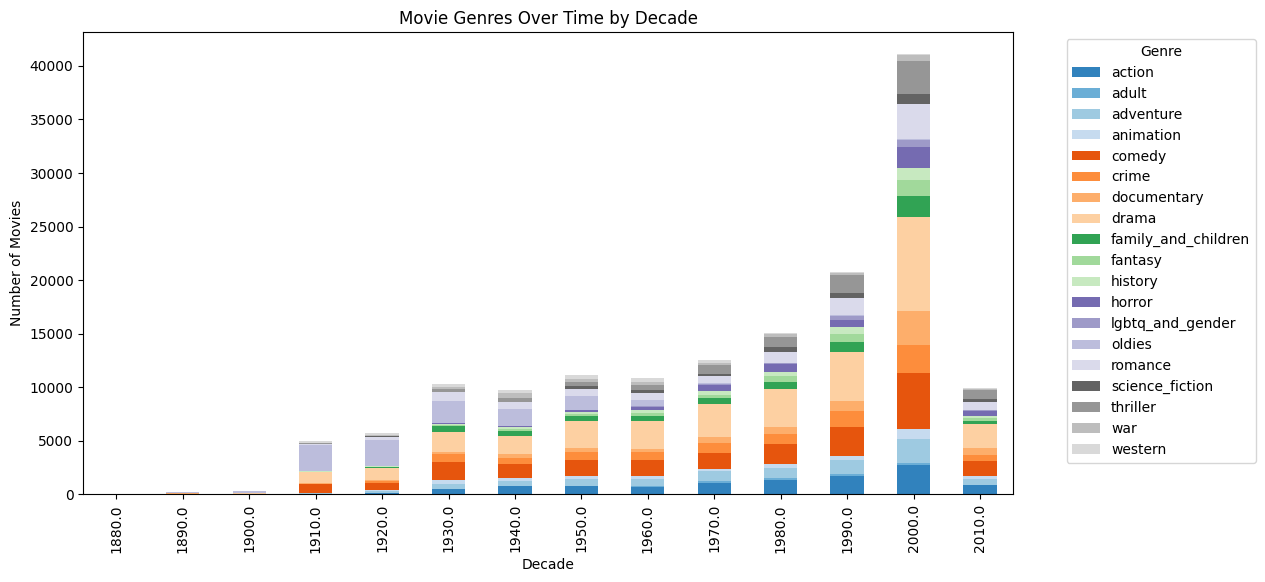

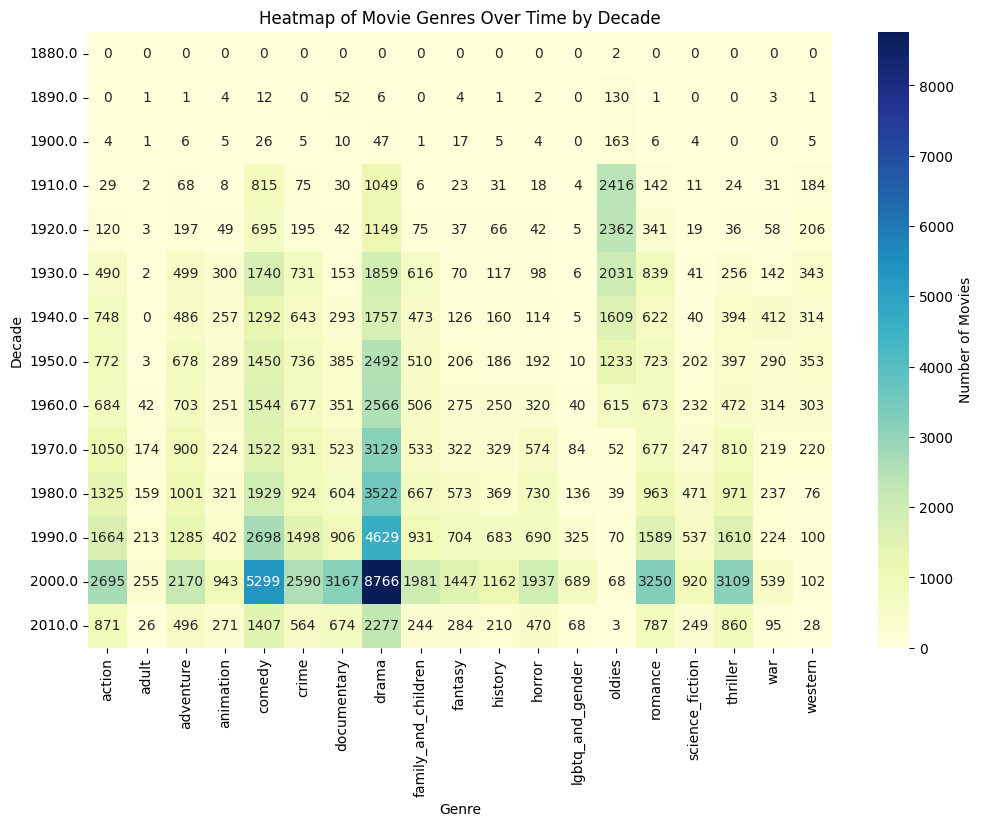

In [93]:
import matplotlib.cm as cm

# Extract the decade from the 'date' column
movies_dataframe['decade'] = (movies_dataframe['date'] // 10) * 10
# Create a new DataFrame with columns for 'decade' and 'new_genre'
df_stacked = movies_dataframe[['decade', 'new_genre']].explode('new_genre')
# Count occurrences of each genre per decade
genre_counts = df_stacked.groupby(['decade', 'new_genre']).size().unstack(fill_value=0)


#Do a stack plot to see which genres make up how much of the total number of movies
# Get custom colors for each genre
cmap = cm.get_cmap('tab20c', len(genre_counts.columns))
colors = {genre: cmap(i) for i, genre in enumerate(genre_counts.columns)}

# Create a stacked bar plot
plt.figure(figsize=(12, 6))
genre_counts.plot(kind='bar', stacked=True, figsize=(12, 6), color=colors)
x_labels = ['{}s'.format(decade) for decade in genre_counts.index]
ax.set_xticklabels(x_labels)
plt.title('Movie Genres Over Time by Decade')
plt.xlabel('Decade')
plt.ylabel('Number of Movies')
plt.legend(title='Genre', loc='upper left', bbox_to_anchor=(1.05, 1))


#Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(genre_counts, cmap="YlGnBu", annot=True, fmt='d', cbar_kws={'label': 'Number of Movies'})
plt.title('Heatmap of Movie Genres Over Time by Decade')
plt.xlabel('Genre')
plt.ylabel('Decade')

#sns.heatmap(genre_counts, cmap="YlGnBu", annot=True, fmt='d', cbar_kws={'label': 'Number of Movies'})
#plt.title('Heatmap of Movie Genres Over Time by Decade')
#plt.xlabel('Genre')
#plt.ylabel('Decade')
plt.show()

We can see that there has been a general increase in movies over the decades. This is not necessarily specific to the individual genres, however, we do see differences the increase of the number of movies. One outlier is the oldies genre which includes, silent movies, black and white movies and so on, there are less and less movies made that fall into this category.
Since the dataset only goes until 2016 it makes sense that we cannot see the general increase in number of movies over the years, as we do not get the data for the full decade. So when considering decades it might make sense to only consider the data until the year 2010.



5.1.b) see how significant the difference is between the trend of increasing movies over the years compared to the individual genres.

5.2) plot movie box revenues of regions against time. How do we want to take the effect of inflation into account?

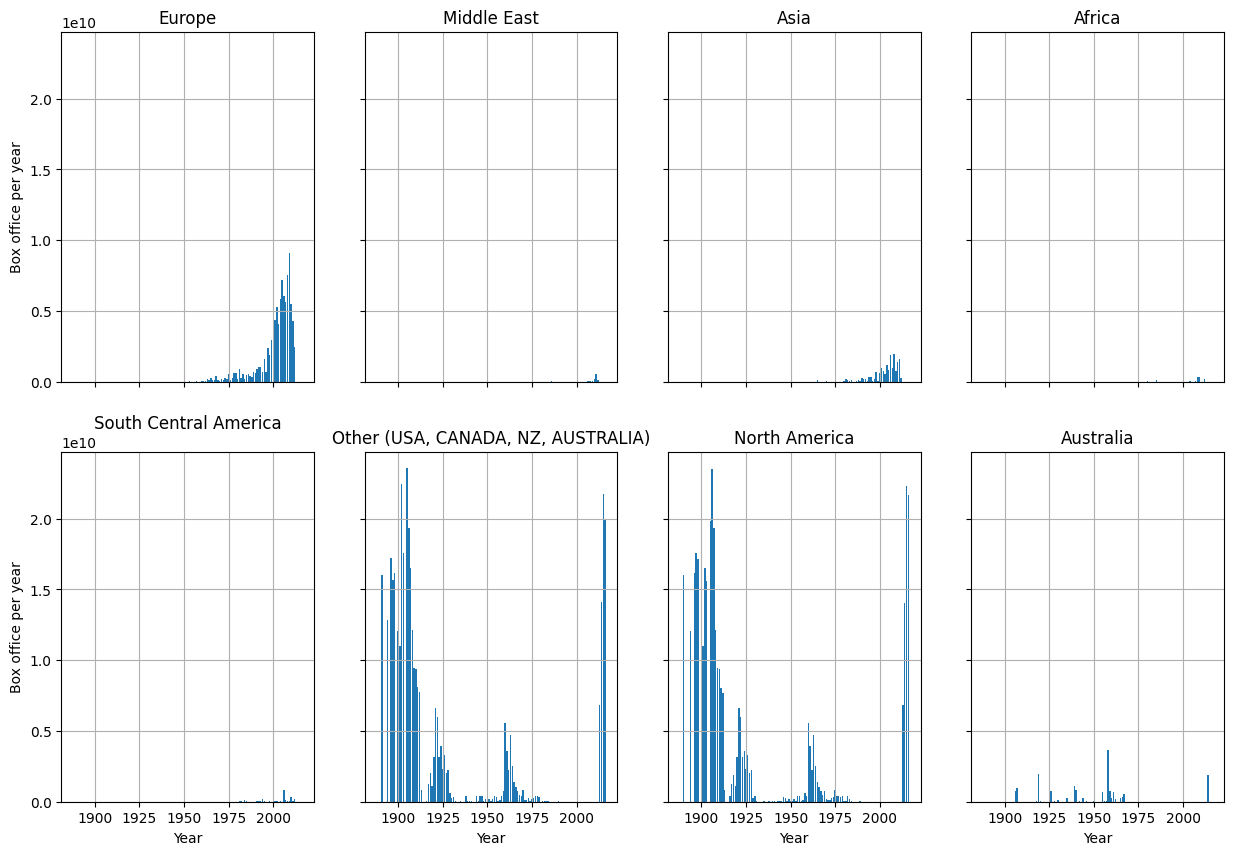

In [33]:
#Using the regions from
# Check how many movies are contained for each subdivision over time, constructing subplots with individual y-axes

fig, axs = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True)

# Check for Region Europe
boxoffice_per_year_europe = filtered_europe_movies.groupby('date')['box_office'].sum()
axs[0, 0].bar(boxoffice_per_year_europe.index, boxoffice_per_year_europe.values)
axs[0, 0].set_title('Europe')


# Check for Region Middle East
boxoffice_per_year_middle_east = filtered_middle_east_movies.groupby('date')['box_office'].sum()
axs[0, 1].bar(boxoffice_per_year_middle_east.index, boxoffice_per_year_middle_east.values)
axs[0, 1].set_title('Middle East')

# Check for Region Asia
boxoffice_per_year_asia = filtered_asia_movies.groupby('date')['box_office'].sum()
axs[0, 2].bar(boxoffice_per_year_asia.index, boxoffice_per_year_asia.values)
axs[0, 2].set_title('Asia')

# Check for Region Africa
boxoffice_per_year_africa = filtered_africa_movies.groupby('date')['box_office'].sum()
axs[0, 3].bar(boxoffice_per_year_africa.index, boxoffice_per_year_africa.values)
axs[0, 3].set_title('Africa')

# Check for region South Central America
boxoffice_per_year_south_central_america = filtered_south_central_america_movies.groupby('date')['box_office'].sum()
axs[1, 0].bar(boxoffice_per_year_south_central_america.index, boxoffice_per_year_south_central_america.values)
axs[1, 0].set_title('South Central America')

# Check for region Other (includes USA, Australia, New Zealand, Canada)
boxoffice_per_year_other = filtered_other_movies.groupby('date')['box_office'].sum()
axs[1, 1].bar(movies_per_year_other.index, boxoffice_per_year_other.values)
axs[1, 1].set_title('Other (USA, CANADA, NZ, AUSTRALIA)')

# Check for region North America
boxoffice_per_year__north_america = filtered_north_america_movies.groupby('date')['box_office'].sum()
axs[1, 2].bar(movies_per_year_north_america.index, boxoffice_per_year__north_america.values)
axs[1, 2].set_title('North America')

#Check for region Australia
boxoffice_per_year__australia = filtered_australia_movies.groupby('date')['box_office'].sum()
axs[1, 3].bar(movies_per_year_australia.index, boxoffice_per_year__australia.values)
axs[1, 3].set_title('Australia')




for ax in axs.flat:
    ax.set(xlabel='Year', ylabel='Box office per year')
    ax.grid(True)

    
# Hide x labels and tick labels for top plots and y ticks for right plots.

for ax in axs.flat:
    ax.label_outer()

plt.show()

> We can see that the box office of the different regions vary. Europe's box office values go up with time. In the Middle East, Asia, Africa and South Central America the boxoffice values are quite low compared to the others. For the Other regions we get interesting results as there are multiple individual peaks. In order to check the result we also added individual results for North America and Australia with similar results. As we saw in 3.2 There are 73340 NAN values in the box_office column of the dataset, which corresponds to a percentage of 89.72 % of the box_office column total data.z
This is a high number in NANs showing, that these plots and the data underlying them is not very helpful with analyzing the movie dataset.

5.3) plot average number of languages spoken in movies against time for each region.

In [128]:
#maybe add code to 3.1!!
regions = {'europe_countries': ['United Kingdom', 'Croatia', 'Ukraine', 'Luxembourg', 'Belgium', 'Sweden', 'Switzerland', 'Greece', 'Ireland',  'Iceland', 'Poland', 'Italy', 'Denmark',  'Scotland', 'Finland', 'Albania', 'Portugal', 'Northern Ireland', 'Austria',  'Netherlands', 'Monaco', 'Spain',  'England',  'German Democratic Republic', 'France', 'Nazi Germany', 'West Germany',  'Germany', 'Weimar Republic', 'Kingdom of Italy', 'Kingdom of Great Britain', 'Isle of Man', 'Lithuania', 'Malta', 'Czech Republic',  'Czechoslovakia', 'Slovakia', 'Romania', 'Norway', 'Serbia', 'Slovenia', 'Bulgaria', 'Slovak Republic', 'Ukrainian SSR',  'Ukranian SSR',  'Estonia',  'Soviet occupation zone', 'Bosnia and Herzegovina', 'Socialist Federal Republic of Yugoslavia', 'Yugoslavia', 'Wales', 'Hungary', 'Federal Republic of Yugoslavia',  'Serbia and Montenegro', 'Republic of Macedonia', 'Montenegro', 'Cyprus', 'Crime'],
'middle_east_countries': ['Lebanon', 'Iran', 'United Arab Emirates', 'Iraq', 'Turkey', 'Iraqi Kurdistan', 'Jordan', 'Mandatory Palestine', 'Palestinian territories', 'Palestinian Territories', 'Armenia', 'Georgia', 'Kuwait', 'Georgian SSR', 'Israel', 'Turkmenistan', 'Qatar', 'Bahrain', 'Azerbaijan'],
'asia_countries': ['Hong Kong', 'Nepal', 'Indonesia', 'China',  'Taiwan', 'Cambodia', 'Vietnam', 'Sri Lanka', 'Singapore', 'Thailand', 'Mongolia', 'Korea', 'India', 'Malaysia', 'South Korea', 'Philippines', 'Republic of China', 'Japan',  'Soviet Union', 'Bangladesh', 'Russia', 'Pakistan', 'Uzbekistan', 'Afghanistan', 'Macau', 'Uzbek SSR', 'Bhutan', 'Burma'],
'africa_countries': ['Guinea', 'Cameroon', 'Democratic Republic of the Congo', 'Tunisia', 'Congo', 'Ethiopia', 'Nigeria', 'Libya', 'Zimbabwe', 'Morocco',  'Mali', 'Egypt', 'Burkina Faso', 'Senegal', 'Kenya', 'South Africa', 'Algeria', 'Zambia', 'Guinea-Bissau'],
'south_central_america_countries': ['Mexico', 'Colombia', 'Uruguay', 'Puerto Rico',  'Costa Rica', 'Chile', 'Venezuela', 'Peru', 'Bolivia', 'Brazil', 'Cuba', 'Panama', 'Argentina', 'Haiti', 'Bahamas', 'Jamaica', 'Aruba'],
'other_countries': ['United States of America', 'Canada', 'Australia', 'New Zealand'],
'outlier_countries': [ 'German Language', 'Malayalam Language'] }

def find_region(country_or_countries, regions):
    if isinstance(country_or_countries, list):
        # since the country is stored as a list and there might be multiple so we have to check them too
        for country in country_or_countries:
            for region, countries in regions.items():
                if country in countries:
                    return region
    return None

# Create a new column 'world_region' in the DataFrame
movies_dataframe['world_region'] = movies_dataframe['country'].apply(find_region, regions = regions)

movies_dataframe.head()

,id_wiki,id_freebase,name,date,box_office,runtime,lang,country,genre,new_genre,world_region
0,975900,/m/03vyhn,Ghosts of Mars,2001.0,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,...","[action, adventure, fantasy, horror, science_f...",other_countries
1,3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000.0,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]","[crime, documentary, drama]",other_countries
2,28463795,/m/0crgdbh,Brun bitter,1988.0,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]","[crime, drama]",europe_countries
3,9363483,/m/0285_cd,White Of The Eye,1987.0,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri...","[adult, thriller]",europe_countries
4,261236,/m/01mrr1,A Woman in Flames,1983.0,NaN,106.0,[German Language],[Germany],[Drama],[drama],europe_countries


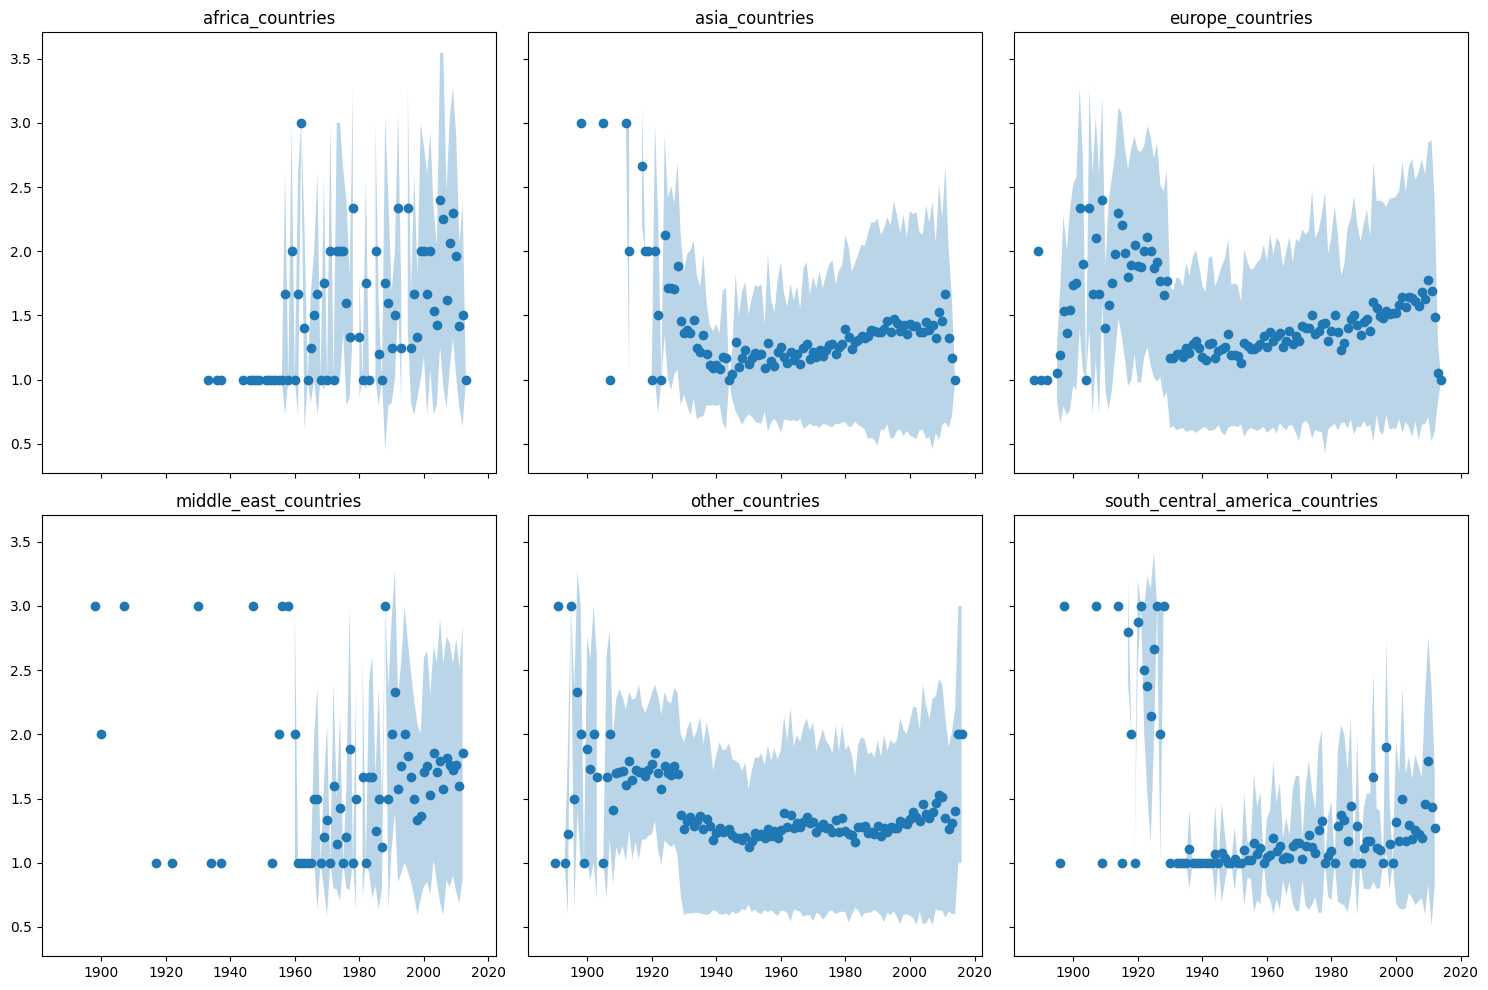

In [94]:
# Group by 'date' and 'region' and calculate the mean number of languages spoken in the 'lang' column for each year and region
lang_per_year_region = movies_dataframe.groupby(['date', 'world_region'])[['lang']].apply(lambda x: pd.Series({'mean': np.mean(x['lang'].apply(len)), 'variance': np.var(x['lang'].apply(len))}))

# Reset the index to make 'world_region' a regular column
lang_per_year_region = lang_per_year_region.reset_index()

# Pivot the DataFrame for plotting
lang_per_year_region_pivot = lang_per_year_region.pivot(index='date', columns='world_region', values=['mean', 'variance'])

# Remove 'outlier_countries' from the regions list
regions = [region for region in lang_per_year_region_pivot.columns.get_level_values(1).unique() if region != 'outlier_countries']

#Plot in subplots
fig, axs = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)

# Flatten the axs array for easy iteration
axs_flat = axs.flatten()

# Plot mean values
for i, region in enumerate(regions):
        region_data_mean = lang_per_year_region_pivot[('mean', region)]
        region_data_variance = lang_per_year_region_pivot[('variance', region)]

        axs_flat[i].plot(region_data_mean, 'o', label=f'{region} - Mean')
        axs_flat[i].fill_between(region_data_mean.index, region_data_mean - np.sqrt(region_data_variance), region_data_mean + np.sqrt(region_data_variance), alpha=0.3)

         # Add title and legend to each subplot
        axs_flat[i].set_title(region)
            

# Adjust layout
plt.tight_layout()
plt.show()


We can see that there we do not have enough movies for each region to be able to consistently analyze the number of languages spoken in the movies made in those regions. The closer we come to today the more movies we get and therefore the more dots(means) and also more variance. It is quite interesting to see that there was a drop around 1930 in Europe and the US. We might be able to analyze this to see if we can link it to one historical event. However, we would need to do further analyses to see whether this drop was maybe linked to the number of movies and so on.

5.4) plot percentage of women in movies over time in different regions. How does this plot change when looking at percentage of female main characters?

In [23]:
# Creating a copy of the orgininal characters dataframe, with only the columns we are interested in in this part

characters_gender_df = characters[['id_wiki_movie', 'actor_gender']].copy()


# Number of characters per movie

characters_per_movie = characters_gender_df.value_counts(subset = ['id_wiki_movie'])
characters_per_movie.name = 'characters_per_movie'


# Number of characters per movie for each genre

women_per_movie = characters_gender_df.value_counts(subset = ['id_wiki_movie', 'actor_gender'])


# Number of female characters per movie (set number of male characters to 0 and then sum characters from both genders)

women_per_movie = women_per_movie.to_frame().reset_index()
women_per_movie.loc[women_per_movie['actor_gender'] != 'F', 'count'] = 0
women_per_movie = women_per_movie.drop(['actor_gender'], axis = 1)
women_per_movie = women_per_movie.groupby('id_wiki_movie')['count'].sum()
women_per_movie.name = 'women_per_movie'


# Merge number of characters and number of female characters per movie into one dataframe : character_stats_per_movie

character_stats_per_movie = characters_per_movie.to_frame().merge(women_per_movie, how = 'left', on = 'id_wiki_movie')


# Calculate proportion of female characters per movie

character_stats_per_movie['proportion_women'] = character_stats_per_movie['women_per_movie']/character_stats_per_movie['characters_per_movie']
character_stats_per_movie.index.names = ['id_wiki']


# Merge proportion of female characters with movies dataframe
# Allow to have information about time and places related to proportion of female characters

character_stats_movies = character_stats_per_movie.merge(movies_df, how = 'left', on = 'id_wiki')
character_stats_movies = character_stats_movies[['proportion_women', 'date', 'country']]

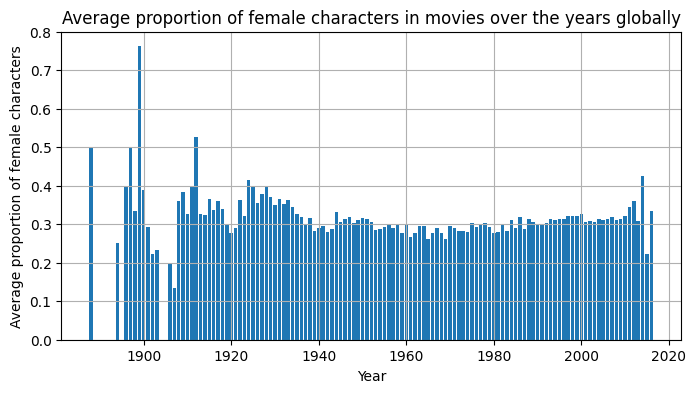

In [24]:
# Average proportion of female characters in movies per year globally

proportion_women_per_year = character_stats_movies.groupby('date')['proportion_women'].mean()


# Plotting the average proportion of female characters in movies per year

plt.figure(figsize = (8, 4))
plt.bar(proportion_women_per_year.index, proportion_women_per_year.values)
plt.xlabel('Year')
plt.ylabel('Average proportion of female characters')
plt.title('Average proportion of female characters in movies over the years globally')
plt.grid(True)
plt.show()

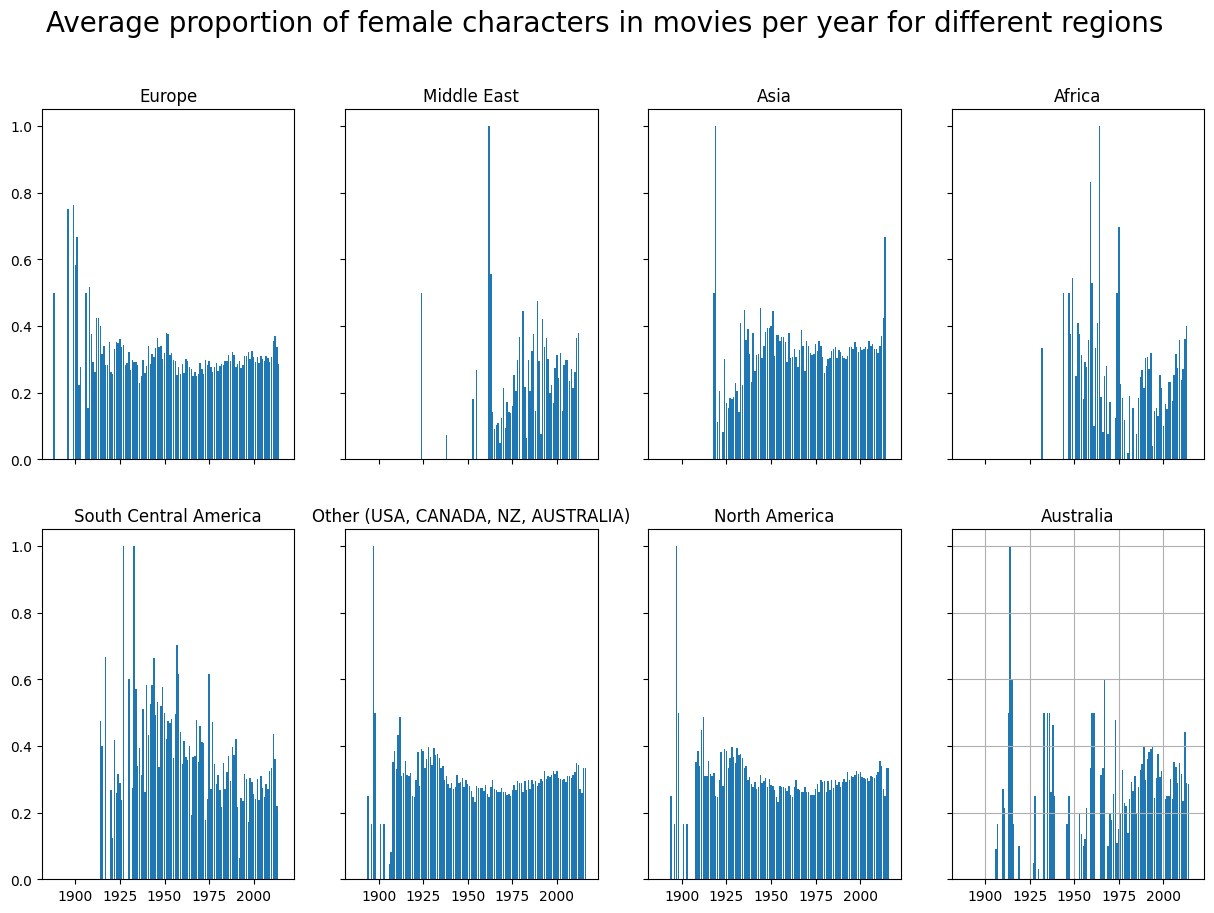

In [25]:
# Plot average proportion of female characters in movies per year per region

fig, axs = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Average proportion of female characters in movies per year for different regions', fontsize = 20)


# Region : Europe

character_stats_movies_europe = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in europe_countries))]
proportion_women_per_year_europe = character_stats_movies_europe.groupby('date')['proportion_women'].mean()

axs[0, 0].bar(proportion_women_per_year_europe.index, proportion_women_per_year_europe.values)
axs[0, 0].set_title('Europe')


# Region : Middle East

character_stats_movies_middle_east = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in middle_east_countries))]
proportion_women_per_year_middle_east = character_stats_movies_middle_east.groupby('date')['proportion_women'].mean()

axs[0, 1].bar(proportion_women_per_year_middle_east.index, proportion_women_per_year_middle_east.values)
axs[0, 1].set_title('Middle East')


# Region : Asia

character_stats_movies_asia = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in asia_countries))]
proportion_women_per_year_asia = character_stats_movies_asia.groupby('date')['proportion_women'].mean()

axs[0, 2].bar(proportion_women_per_year_asia.index, proportion_women_per_year_asia.values)
axs[0, 2].set_title('Asia')


# Region : Africa

character_stats_movies_africa = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in africa_countries))]
proportion_women_per_year_africa = character_stats_movies_africa.groupby('date')['proportion_women'].mean()

axs[0, 3].bar(proportion_women_per_year_africa.index, proportion_women_per_year_africa.values)
axs[0, 3].set_title('Africa')


# Region : South Central America

character_stats_movies_south_central_america = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in south_central_america_countries))]
proportion_women_per_year_south_central_america = character_stats_movies_south_central_america.groupby('date')['proportion_women'].mean()

axs[1, 0].bar(proportion_women_per_year_south_central_america.index, proportion_women_per_year_south_central_america.values)
axs[1, 0].set_title('South Central America')


# Region : Other

character_stats_movies_other = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in other_countries))]
proportion_women_per_year_other = character_stats_movies_other.groupby('date')['proportion_women'].mean()

axs[1, 1].bar(proportion_women_per_year_other.index, proportion_women_per_year_other.values)
axs[1, 1].set_title('Other (USA, CANADA, NZ, AUSTRALIA)')


# Region : North America

character_stats_movies_north_america = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in north_america_countries))]
proportion_women_per_year_north_america = character_stats_movies_north_america.groupby('date')['proportion_women'].mean()

axs[1, 2].bar(proportion_women_per_year_north_america.index, proportion_women_per_year_north_america.values)
axs[1, 2].set_title('North America')


# Region : Australia

character_stats_movies_australia = character_stats_movies[character_stats_movies['country'].apply(lambda x: any(item in x for item in australia_countries))]
proportion_women_per_year_australia = character_stats_movies_australia.groupby('date')['proportion_women'].mean()

axs[1, 3].bar(proportion_women_per_year_australia.index, proportion_women_per_year_australia.values)
axs[1, 3].set_title('Australia')


plt.grid(True)
plt.show()

In general, we can see that the proportion of female characters is not drastically different around the world. We can also see that it is significantly lower than 50%, closer to 30%, suggesting that the gender distribution in movies is not equal. 

One region that stands out is South Central America, where the proportion of female characters is slightly higher than in other regions.

We can also note that there is much less data in the Middle East, Africa and Australia regions. This could be due to less movies being produced in these countries, or a lack of information about the gender of characters.

5.5) Plot average age actors over the years and in different regions at movie release date. How does this change if we separate age data based on gender?

5.6) Plot average # of ethnicites of characters represented in movies over years in different regions. Does this change when looking at the main character?

In [64]:
# TO DO : should  I process the ethnicities data first (classify into broader ethnicities)


# Creating a copy of the orgininal characters dataframe, with only the columns we are interested in in this part

characters_ethnicity_df = characters_ethnicities[['id_wiki_movie', 'actor_ethnicity']].copy()


# Number of ethnicities per movie

ethnicities_per_movie = characters_ethnicity_df.value_counts(subset = ['id_wiki_movie', 'actor_ethnicity'])
ethnicities_per_movie = ethnicities_per_movie.to_frame().reset_index('actor_ethnicity')
ethnicities_per_movie.loc[:, 'count'] = 1
ethnicities_per_movie = ethnicities_per_movie.groupby('id_wiki_movie')['count'].sum()
ethnicities_per_movie.index.names = ['id_wiki']
ethnicities_per_movie.name = 'ethnicities_per_movie'


# Merge number of ethnicities of characters with movies dataframe
# Allow to have information about time and places related to the number of different ethnicities

character_ethnicities_movies = ethnicities_per_movie.to_frame().merge(movies_df, how = 'left', on = 'id_wiki')
character_ethnicities_movies = character_ethnicities_movies[['ethnicities_per_movie', 'date', 'country']]

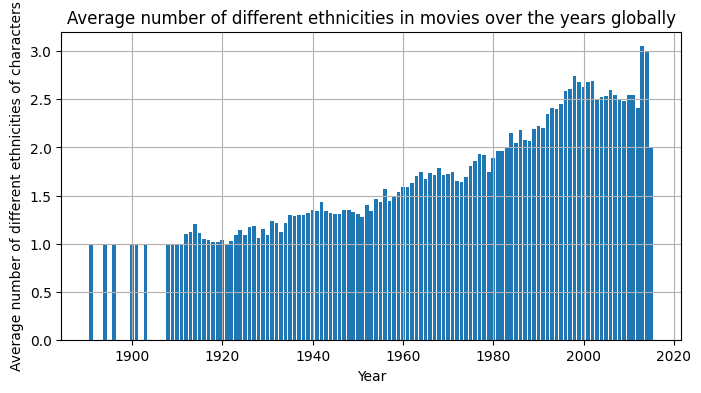

In [49]:
# Average number of different ethnicities in movies per year globally

different_ethnicities_per_year = character_ethnicities_movies.groupby('date')['ethnicities_per_movie'].mean()


# Plotting the average number of different ethnicities in movies per year

plt.figure(figsize = (8, 4))
plt.bar(different_ethnicities_per_year.index, different_ethnicities_per_year.values)
plt.xlabel('Year')
plt.ylabel('Average number of different ethnicities of characters')
plt.title('Average number of different ethnicities in movies over the years globally')
plt.grid(True)
plt.show()

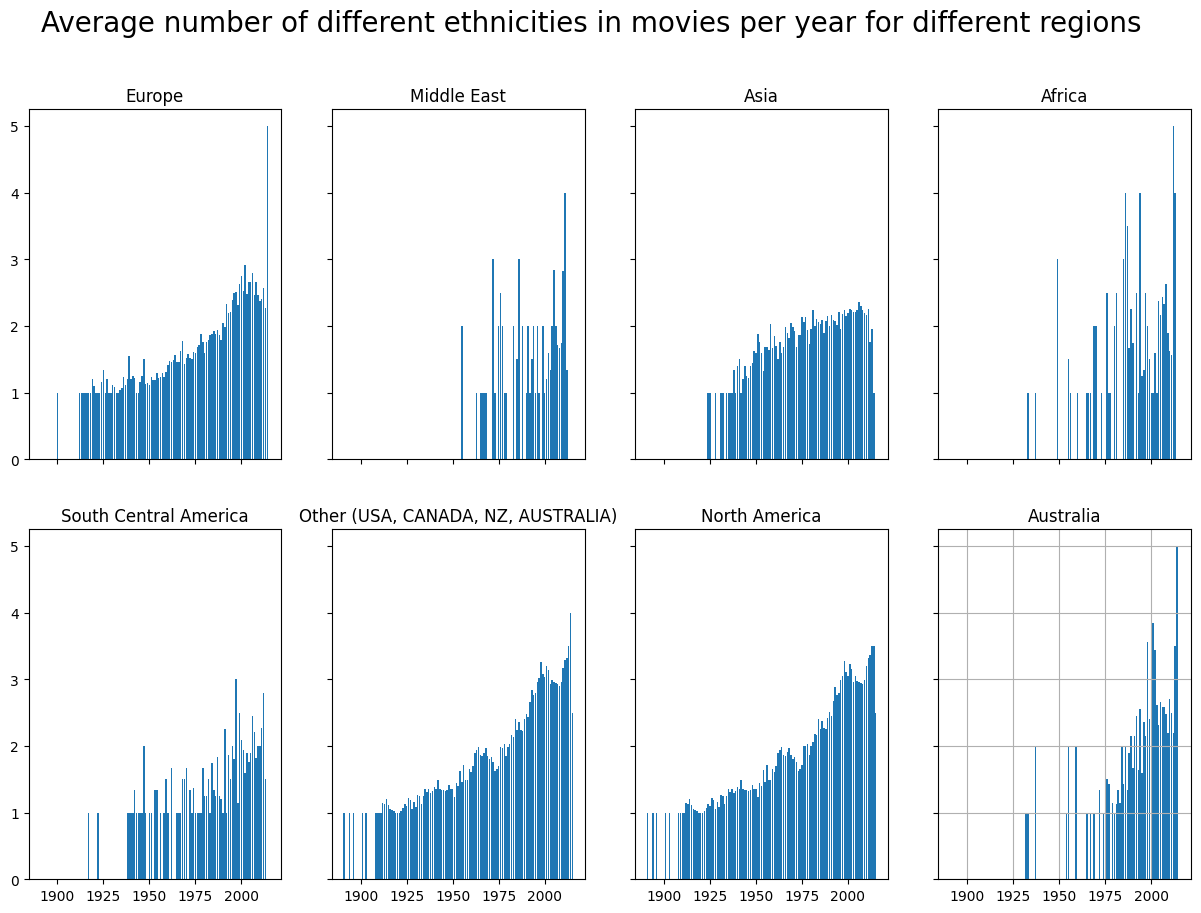

In [63]:
# Plot average number of different ethnicities in movies per year per region

fig, axs = plt.subplots(2, 4, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle('Average number of different ethnicities in movies per year for different regions', fontsize = 20)


# Region : Europe

character_ethnicities_movies_europe = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in europe_countries))]
different_ethnicities_per_year_europe = character_ethnicities_movies_europe.groupby('date')['ethnicities_per_movie'].mean()

axs[0, 0].bar(different_ethnicities_per_year_europe.index, different_ethnicities_per_year_europe.values)
axs[0, 0].set_title('Europe')


# Region : Middle East

character_ethnicities_movies_middle_east = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in middle_east_countries))]
different_ethnicities_per_year_middle_east = character_ethnicities_movies_middle_east.groupby('date')['ethnicities_per_movie'].mean()

axs[0, 1].bar(different_ethnicities_per_year_middle_east.index, different_ethnicities_per_year_middle_east.values)
axs[0, 1].set_title('Middle East')


# Region : Asia

character_ethnicities_movies_asia = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in asia_countries))]
different_ethnicities_per_year_asia = character_ethnicities_movies_asia.groupby('date')['ethnicities_per_movie'].mean()

axs[0, 2].bar(different_ethnicities_per_year_asia.index, different_ethnicities_per_year_asia.values)
axs[0, 2].set_title('Asia')


# Region : Africa

character_ethnicities_movies_africa = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in africa_countries))]
different_ethnicities_per_year_africa = character_ethnicities_movies_africa.groupby('date')['ethnicities_per_movie'].mean()

axs[0, 3].bar(different_ethnicities_per_year_africa.index, different_ethnicities_per_year_africa.values)
axs[0, 3].set_title('Africa')


# Region : South Central America

character_ethnicities_movies_south_central_america = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in south_central_america_countries))]
different_ethnicities_per_year_south_central_america = character_ethnicities_movies_south_central_america.groupby('date')['ethnicities_per_movie'].mean()

axs[1, 0].bar(different_ethnicities_per_year_south_central_america.index, different_ethnicities_per_year_south_central_america.values)
axs[1, 0].set_title('South Central America')


# Region : Other

character_ethnicities_movies_other = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in other_countries))]
different_ethnicities_per_year_other = character_ethnicities_movies_other.groupby('date')['ethnicities_per_movie'].mean()

axs[1, 1].bar(different_ethnicities_per_year_other.index, different_ethnicities_per_year_other.values)
axs[1, 1].set_title('Other (USA, CANADA, NZ, AUSTRALIA)')


# Region : North America

character_ethnicities_movies_north_america = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in north_america_countries))]
different_ethnicities_per_year_north_america = character_ethnicities_movies_north_america.groupby('date')['ethnicities_per_movie'].mean()

axs[1, 2].bar(different_ethnicities_per_year_north_america.index, different_ethnicities_per_year_north_america.values)
axs[1, 2].set_title('North America')


# Region : Australia

character_ethnicities_movies_australia = character_ethnicities_movies[character_ethnicities_movies['country'].apply(lambda x: any(item in x for item in australia_countries))]
different_ethnicities_per_year_australia = character_ethnicities_movies_australia.groupby('date')['ethnicities_per_movie'].mean()

axs[1, 3].bar(different_ethnicities_per_year_australia.index, different_ethnicities_per_year_australia.values)
axs[1, 3].set_title('Australia')


plt.grid(True)
plt.show()

We can see that the number of ethnicities represented in movies has greatly increased over time. Before the 1950s, mainly 1 ethnicity was represented, whereas nowadays there are about 2-4 different ethnicities represented in each movie, on average. 

It seems like the region that portrays the most diversity through its movies is North America.

We notice that there is again a lack of information for the same regions as before : Middle East, Africa and Australia. This could be due to less movies being produced in those countries, or a lack of specific information about the actors' ethnicities. 

As a follow-up analysis it would be interesting to look at which ethnicities were most represented and whether this depends on the region or not.

... Elaborate on further questions mentioned in the readme.

## 6. Diving into diverse societal events

6.1) Creation of a "word cloud" for each historical event. What are the most common words used in a plot summary?

6.2) Find the typical main character and the typical villain of each era. What adjectives describe them. Find the "most representative main character/villain" for each era. 

--> It might be a good idea to represent the specific interesting findings that we found in the "general overview" in the relative time period it was found in. (e.g. higher representation of LGBTQ+ characters may be mentioned in the corresponding era it was found in). Does not really make a lot of sense to mention in the WWII era that we *did not* find a high LGBTQ+ representation (unless of course we surprisingly find one). 

### Mapping movies to the historical events they represent

> The focus of our project is to study how societal events are reflected in movies. Initially, we attempted to categorize them based on their genres. However, leading our study solely according to the genres to which the movies belong seems quite challenging, as genres may not accurately reflect historical events. 
>
> As a result, we have decided to adopt another approach by mapping movies to the historical events they are linked to through a keyword search in their plot summaries. To achieve this, we created event-related dictionaries using specialized lexicons. We then engineered metrics to determine whether a movie represents a specific event or not.

In [113]:
movie_plots = plot_summaries.copy()
movie_info = movies.copy()


# Merging movie and plot_summaries datasets

merged_movie_plots = pd.merge(movie_info, movie_plots, how = 'inner', left_on = 'id_wiki', right_on = 'id_wiki_movie').copy()


print(movie_plots.shape)
print(movie_info.shape)
print(merged_movie_plots.shape)

(42303, 2)
(81741, 9)
(42204, 11)


#### 1. Events dictionaries

> We decided to focus our study on nine different events that dominated the past century: WW1, WW2, new technologies emergence, ....<span style="color: red;">COMPLETE IN CHRONOLOGICAL ORDER :D</span>. The dictionaries are defined below and were inspired by content found on the internet (https://www.oed.com/discover/word-lists).

In [114]:
# World War 1 dictionary

ww1_dict = [
    "World War I", "1914", "1916", "1917", "1918", "The Great War", "Verdun", "Somme", "Mustard Gas", "No Man's Land", 
    "Armistice", "Front", "Allied", "Assassination", "Treaty", "Women in Wartime", "Trenches",
    "Shell", "Warfare", "Mobilize", "Treaty of Versailles", "War Effort", "Air Raids",  
    "Colonial Troops", "Chemical", "Rationing", "Unknown Soldier", "Tank", "Battlefield",
]


# World War 2 dictionary 

ww2_dict = [
    "World War II", "1939", "1940", "1941", "1942", "1943", "1944", "1945", "Axis Powers", "Allied Powers", 
    "Hitler", "Churchill", "Roosevelt", "Stalin", "Holocaust", "Pearl Harbor", "Hiroshima", "Nagasaki", "Nazis", "Concentration Camps",
    "Kamikaze", "Fascism", "Dunkirk", "Atomic Bomb", "Nuclear", "Guided Missile", "United Nations", "Enigma Code", "D-Day", "Reich", "Resistance",
    "Marshall Plan", "Gestapo", "Deportation", "Auschwitz", "Bombardment"
]


# LGBT emancipation dictionary

lgbt_dict = [
    "Gay", "Lesbian", "LGBT Pride", "Bisexual", "Drag Queen", "Transexual", "Marriage Equality", "Homosexual", "Comming Out", 
    "Homosexual Rights", "AIDS stigma", "Non Binary", "Queer", "Freddie Mercury", "LGBTQ+", "Two-Spirit", "Transphobia", "Gender Identity",
    "lgbtqia+", "Transgender", "Gender fluid", "asexual", "pansexual"
]


# Technologies dictionary

technologies_dict = [
    "Internet", "Drones", "Rockets", "Computer", "Mobile Phone", "Web", "Robots", "Artificial Intelligence", "Social Media", "Technologies",
    "Gene Editing", "Hackers", "LapTop", "Screen", "Facebook", "Software", "Camera", "instagram", "twitter", "smartphone", "jet"    
]


# Black History dictionary

black_history_dict = [
    'black history', 'slavery', 'abolition', 'emancipation proclamation', 'underground railroad', 'jim crow laws', 
    'segregation', 'montgomery bus boycott', 'martin luther king jr.', 'rosa parks', 'malcolm x', 'black panthers',  
    'frederick douglass', 'harriet tubman', 'sojourner truth', 'booker t. washington', 'w.e.b. du bois',  'civil rights act', 
    'voting rights act', 'black power', 'african american culture', 'harlem renaissance',  'great migration', 'tuskegee airmen', 'buffalo soldiers', 'negro league baseball',  
    'black lives matter', 'kwanzaa', 'haitian revolution', 'madam cj walker', 'tuskegee experiment', 'zora neale hurston', 'shirley chisholm', 'octavius catto',  'black wall street', 
    'black liberation', 'slave rebellion', 'freedom riders', 'hip-hop culture', 'african diaspora', 'american civil war', 'kkk', 'ku klux klan' , 'racism'
]


# Climate Change dictionary

climate_change_dict = [
    'climate change', 'global warming', 'greenhouse gases', 'carbon footprint',  'carbon dioxide', 'methane', 'deforestation', 'rising sea levels', 
    'extreme weather',  'polar ice melting', 'ocean acidification', 'renewable energy', 'sustainable living',  'climate action', 'paris agreement', 'emission reduction', 'climate crisis',  'climate science', 'biodiversity loss', 
    'natural disaster',  'fossil fuels', 'clean energy',  'climate refugees', 'carbon capture', 'climate activism',  'sustainability', 'climate research', 'green energy',  'temperature rise', 'ozone layer' 
]


# Summer of love dictionary

summer_of_love_dict = [
    "summer of love", "1967", "hippie movement", "hippie", "hippies", "counterculture",  "flower power", "peace and love", "woodstock", "haight-ashbury", "be-ins", 
    "grateful dead",  "summer of '67", "flower children", "love generation",  "legacy of the summer of love"
]


# AIDS dictionary

aids_dict = [
    'aids', 'hiv', 'human immunodeficiency virus', 'acquired immunodeficiency syndrome', 'antiretroviral therapy', 'hiv transmission',  'hiv testing', 'aids symptoms', 
    'hiv prevention', 'aids awareness', 'world aids day',  'aids activism', 'freddie mercury', 'hiv-positive', 'hiv-negative', 'sexually transmissible disease'
]


# Women emancipation dictionary 

women_emancipation_dict = [
    "emancipation", "feminism", "suffrage", "equal rights", "gender equality",  "women's liberation", "empowerment", "gender roles", "women's rights",  
    "glass ceiling", "patriarchy", "sexism", "feminist", "abortion", "women in the workplace", "equal pay", "maternity leave",  
    "body positivity", "sexual harassment",  "gender wage gap", "gender discrimination",  "domestic violence", "women's march",  "gender stereotypes", 
    "gender bias", "empowering", "women's health", "contraceptive pill", "birth-control", "gender inequality"
]


In [115]:
# Create a DataFrame for 'events' dictionaries

events = ['WW1', 'WW2', 'LGBT', 'TECHNOLOGIES', 'BLACK HISTORY', 'WOMEN EMANCIPATION', 'SUMMER OF LOVE', 'AIDS', 'CLIMATE CHANGE' ]
words = {'dictionary': [ww1_dict, ww2_dict, lgbt_dict, technologies_dict, black_history_dict, women_emancipation_dict, summer_of_love_dict, aids_dict, climate_change_dict]}
dictionaries_df = pd.DataFrame(data = words, index = events)


# Words have to be lowercase for the keyword search

dictionaries_df['dictionary'] = dictionaries_df['dictionary'].apply(lambda lst: [value.lower() for  value in lst])


display(dictionaries_df)

,dictionary
WW1,"[world war i, 1914, 1916, 1917, 1918, the grea..."
WW2,"[world war ii, 1939, 1940, 1941, 1942, 1943, 1..."
LGBT,"[gay, lesbian, lgbt pride, bisexual, drag quee..."
TECHNOLOGIES,"[internet, drones, rockets, computer, mobile p..."
BLACK HISTORY,"[black history, slavery, abolition, emancipati..."
WOMEN EMANCIPATION,"[emancipation, feminism, suffrage, equal right..."
SUMMER OF LOVE,"[summer of love, 1967, hippie movement, hippie..."
AIDS,"[aids, hiv, human immunodeficiency virus, acqu..."
CLIMATE CHANGE,"[climate change, global warming, greenhouse ga..."


#### 2. Categorizing Movies Through Keyword Search in Plot Summaries

> Our approach involves setting a threshold for each dictionary, indicating the minimum number of matching words required to classify a movie as belonging to an event. 
>
> We decide to initialize it at 1 for all dictionaries, and we'll adjust the thresholds later.

In [116]:
# Dictionaries thresholds are all initialized to '1'

dictionaries_df['threshold'] = 1

In [120]:
# Function to categorize movies based on the threshold for a specific event

def categorize_event(summary, event_dict, threshold):
    summary_words = set(word_tokenize(summary.lower()))
    common_words_count = len(set(event_dict) & summary_words)
    return common_words_count >= threshold


# Function to add columns to DataFrame based on event categories

def add_event_columns(df, dictionaries_df):
    # Iterate over each event in dictionaries_df and add a column to df
    for event, row in dictionaries_df.iterrows():
        event_words = row['dictionary']
        threshold = row['threshold']
        df[event] = df['summary'].apply(lambda x: categorize_event(x, event_words, threshold))
    return df

In [118]:
# The next cell takes a little bit of time to run

In [121]:
movies_events = merged_movie_plots.copy()
movies_events = add_event_columns(movies_events, dictionaries_df)

print(movies_events.columns)


Index(['id_wiki', 'id_freebase', 'name', 'date', 'box_office', 'runtime',
       'lang', 'country', 'genre', 'id_wiki_movie', 'summary', 'WW1', 'WW2',
       'LGBT', 'TECHNOLOGIES', 'BLACK HISTORY', 'WOMEN EMANCIPATION',
       'SUMMER OF LOVE', 'AIDS', 'CLIMATE CHANGE'],
      dtype='object')


In [122]:
filtered_movie_with_events = movies_events[movies_events[events].any(axis=1)].copy()

print(filtered_movie_with_events.shape)

(10058, 20)


> More than 10,000 movies out of 40,000 were selected to represent one or more historical events.

In [123]:
def create_events_belongs_to_column(df, event_columns):
    df['events_belongs_to'] = df.apply(
        lambda row: [event for event in event_columns if row[event]], axis=1
    )
    return df

In [124]:
movies_events_bis = movies_events.copy()
movies_events_bis = create_events_belongs_to_column(movies_events_bis, events).copy()

# Reduce the date column to years only
movies_events_bis['date'] = pd.to_datetime(movies_events_bis['date'], errors = 'coerce', format = 'mixed').dt.year

In [ ]:
#get the movies of each specific event

movies_WW1 = movies_events_bis[movies_events_bis['events_belongs_to'].apply(lambda x: 'WW1' in x)]
movies_WW2 = movies_events_bis[movies_events_bis['events_belongs_to'].apply(lambda x: 'WW2' in x)]
movies_LGBT = movies_events_bis[movies_events_bis['events_belongs_to'].apply(lambda x: 'LGBT' in x)]
movies_technologies = movies_events_bis[movies_events_bis['events_belongs_to'].apply(lambda x: 'TECHNOLOGIES' in x)]
movies_black_history = movies_events_bis[movies_events_bis['events_belongs_to'].apply(lambda x: 'BLACK HISTORY' in x)]
movies_women = movies_events_bis[movies_events_bis['events_belongs_to'].apply(lambda x: 'WOMEN EMANCIPATION' in x)]
movies_summer_love = movies_events_bis[movies_events_bis['events_belongs_to'].apply(lambda x: 'SUMMER OF LOVE' in x)]
movies_aids = movies_events_bis[movies_events_bis['events_belongs_to'].apply(lambda x: 'AIDS' in x)]
movies_climate = movies_events_bis[movies_events_bis['events_belongs_to'].apply(lambda x: 'CLIMATE CHANGE' in x)]

#Print the number of movies per event

print('WW1:', movies_WW1.shape[0])
print('WW2:', movies_WW2.shape[0])
print('LGBT:', movies_LGBT.shape[0])
print('Technologies:', movies_technologies.shape[0])
print('Black History:', movies_black_history.shape[0])
print('Women Emancipation:', movies_women.shape[0])
print('Summer of Love:', movies_summer_love.shape[0])
print('AIDS :', movies_aids.shape[0])
print('Climate Change:', movies_climate.shape[0])

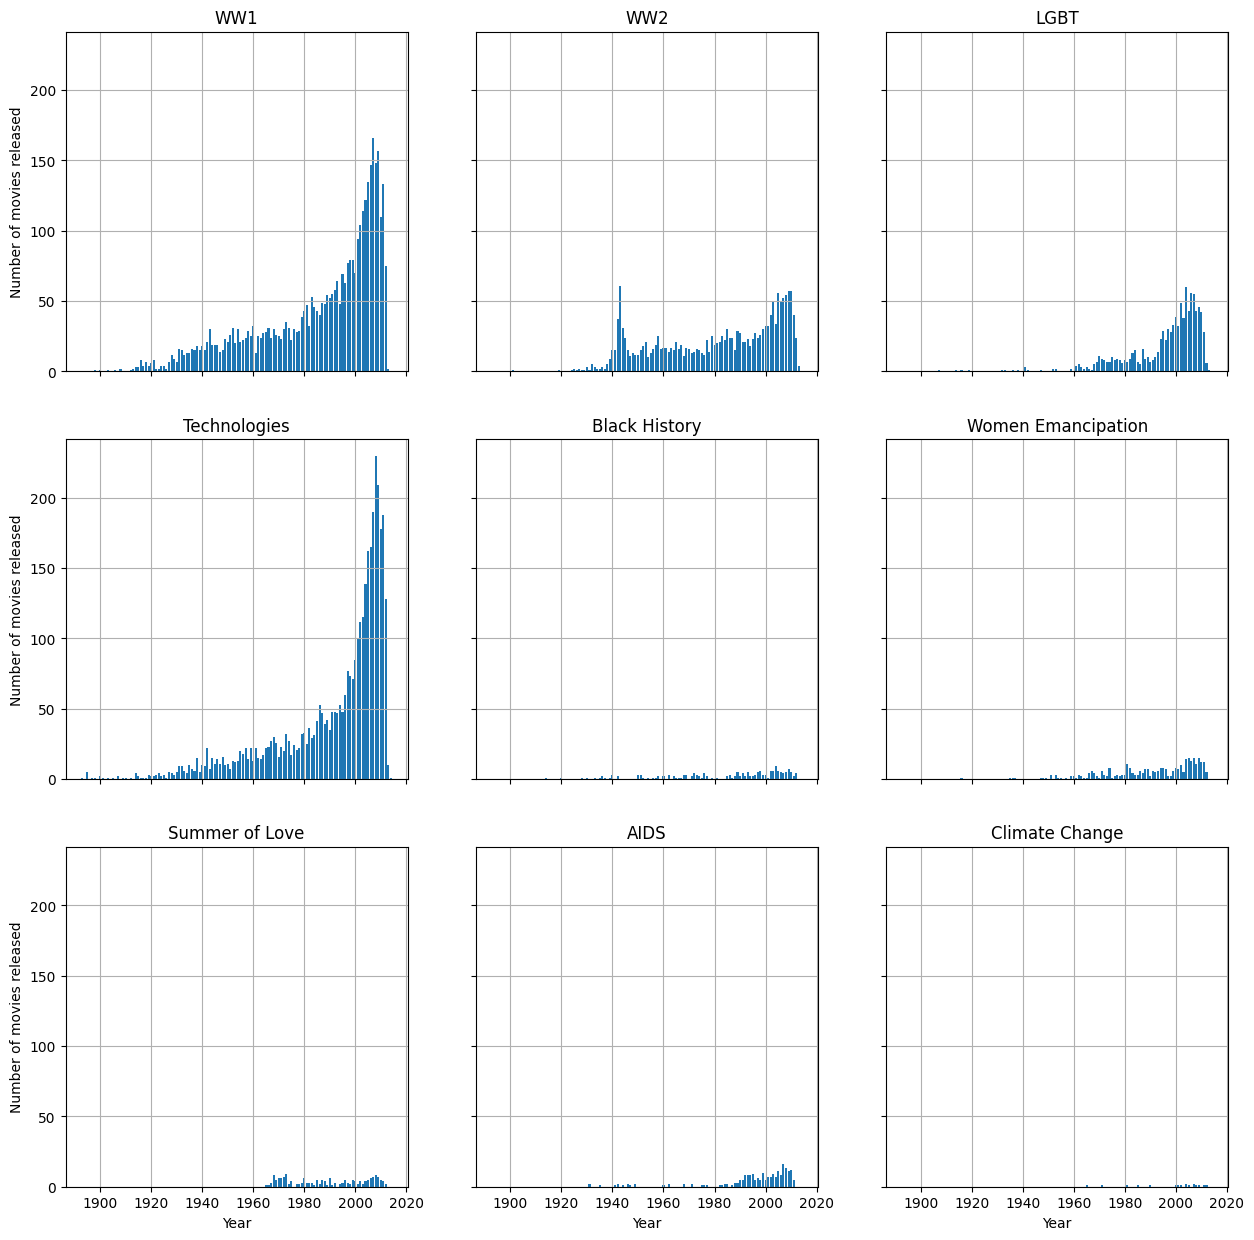

In [95]:
#Create subplots showing the movies by event over the years
fig, axs = plt.subplots(3, 3, figsize=(15, 15), sharex=True, sharey=True)

# WW1

movies_per_year_WW1 = movies_WW1['date'].value_counts()
axs[0, 0].bar(movies_per_year_WW1.index, movies_per_year_WW1.values)
axs[0, 0].set_title('WW1')

# WW2

movies_per_year_WW2 = movies_WW2['date'].value_counts()
axs[0, 1].bar(movies_per_year_WW2.index, movies_per_year_WW2.values)
axs[0, 1].set_title('WW2')

# LGBT

movies_per_year_LGBT = movies_LGBT['date'].value_counts()
axs[0, 2].bar(movies_per_year_LGBT.index, movies_per_year_LGBT.values)
axs[0, 2].set_title('LGBT')

# Technologies

movies_per_year_technologies = movies_technologies['date'].value_counts()
axs[1, 0].bar(movies_per_year_technologies.index, movies_per_year_technologies.values)
axs[1, 0].set_title('Technologies')

# Black history

movies_per_year_black_history= movies_black_history['date'].value_counts()
axs[1, 1].bar(movies_per_year_black_history.index, movies_per_year_black_history.values)
axs[1, 1].set_title('Black History')

# Women emancipation

movies_per_year_women = movies_women['date'].value_counts()
axs[1, 2].bar(movies_per_year_women.index, movies_per_year_women.values)
axs[1, 2].set_title('Women Emancipation')

# Summer of love

movies_per_year_summer_love = movies_summer_love['date'].value_counts()
axs[2, 0].bar(movies_per_year_summer_love.index, movies_per_year_summer_love.values)
axs[2, 0].set_title('Summer of Love')

# AIDS

movies_per_year_aids = movies_aids['date'].value_counts()
axs[2, 1].bar(movies_per_year_aids.index, movies_per_year_aids.values)
axs[2, 1].set_title('AIDS')

# Climate change

movies_per_year_climate = movies_climate['date'].value_counts()
axs[2, 2].bar(movies_per_year_climate.index, movies_per_year_climate.values)
axs[2, 2].set_title('Climate Change')

for ax in axs.flat:
    ax.set(xlabel='Year', ylabel='Number of movies released')
    ax.grid(True)

    
# Hide x labels and tick labels for top plots and y ticks for right plots.

for ax in axs.flat:
    ax.label_outer()

plt.show()

#### 3. Accessing the threshold performance ?

3.1) Events and genres

In [125]:
# DISCLAIMER CETTE PARTIE A ETE INSPIRÉ DE GIANNA
genres_considered = {'action': action, 'adult': adult, 'adventure': adventure, 'animation': animation, 'comedy': comedy, 'crime': crime, 'documentary': documentary, 'drama': drama, 'family_and_children': family_and_children, 'fantasy': fantasy, 'history': history, 'horror': horror, 'oldies': oldies, 'romance': romance, 'science_fiction': science_fiction, 'thriller': thriller, 'war': war, 'western': western, 'lgbtq_and_gender': lgbtq_and_gender}


# Function to add one column to DataFrame which will be filled by a list of genre categories 

def update_new_genre_column(df, genres_considered):
    df['new_genre'] = None

    for name, genre_list in genres_considered.items():
        mask = df['genre'].apply(lambda x: any(item in x for item in genre_list))
        df.loc[mask, 'new_genre'] = df.loc[mask, 'new_genre'].apply(lambda x: [] if x is None else x)
        df.loc[mask, 'new_genre'] = df.loc[mask, 'new_genre'].apply(lambda x: x + [name] if isinstance(x, list) else [name])

    return df


# UN MERGED AVEC LA PARTIE DE GIANNA POURRAIT SUFFIR

movies_events_genres = movies_events_bis.copy()
movies_events_genres = update_new_genre_column(movies_events_bis, genres_considered)

In [126]:
def count_genres_for_event(df, event_column):
    # Explode the 'new_genre' column
    df_expanded = df.copy()
    df_expanded = df_expanded.explode('new_genre')
    
    # Filter rows where the event_column is True
    filtered_df = df_expanded[df_expanded[event_column] == 1]
    
    # Group by 'new_genre' and count occurrences
    genre_counts = filtered_df.groupby('new_genre').size()
    
    return genre_counts

In [127]:
lgbt_counts = count_genres_for_event(movies_events_genres, 'LGBT')
print(lgbt_counts)

new_genre
action                  75
adult                   47
adventure               63
animation               16
comedy                 484
crime                  156
documentary             86
drama                  604
family_and_children    123
fantasy                 42
history                 63
horror                  83
lgbtq_and_gender       397
oldies                  26
romance                286
science_fiction         26
thriller               124
war                     17
western                  6
dtype: int64


In [ ]:
#COMPARE WITH LGBTQ_GENDER COUNT IN NEW_MODEL EXPLODED?

In [142]:
def calculate_genre_proportions_by_event(df):
    genre_proportions_by_event = pd.DataFrame()
    
    for event in df['events_belongs_to'].explode().unique():
        
        genre_counts = df[df['events_belongs_to'].apply(lambda x: event in x)]['new_genre'].explode().value_counts()
        genre_proportions = 100 * genre_counts / genre_counts.sum()
        genre_proportions_by_event[event] = genre_proportions

    return genre_proportions_by_event

In [143]:
result = calculate_genre_proportions_by_event(movies_events_genres.copy())
result = result.dropna(axis=1, how='all')


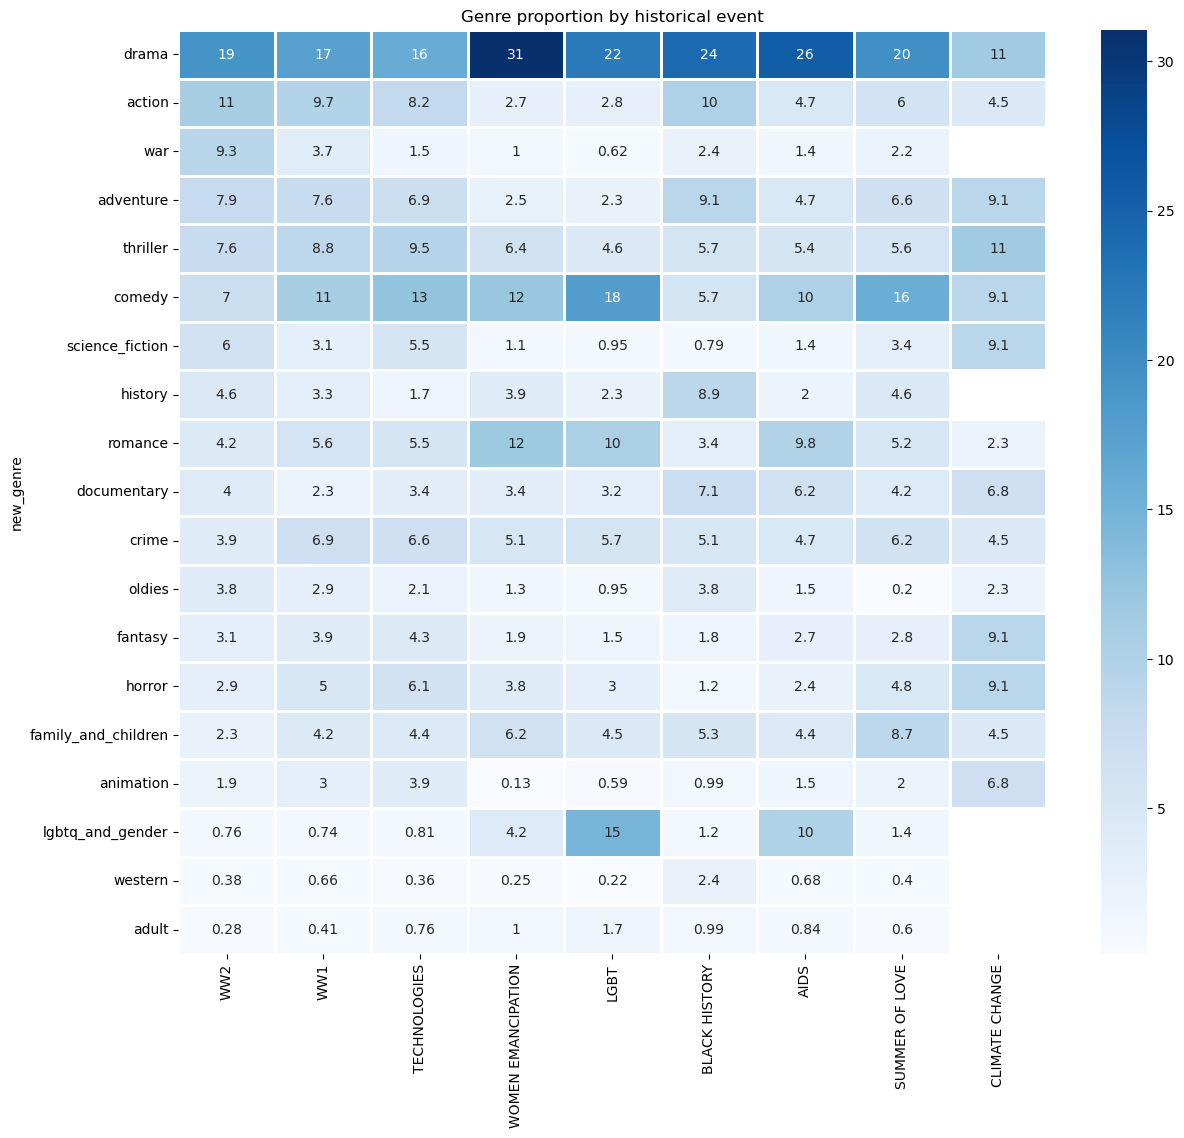

In [144]:
plt.figure(figsize=(14,12))
heat_map = sns.heatmap(genre_proportions_by_event, linewidth = 1 , annot = True, cmap='Blues')
plt.title( "Genre proportion by historical event" )
plt.show()